In [19]:
import os
import glob
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd

# =========================
# USER SETTINGS (EDIT THESE)
# =========================
SCENARIOS = {
    "Light":  r"Light/Output-Default-Priority",
    "Medium": r"Medium/Output-Default-Priority",
    "Heavy":  r"Heavy/Output-Default-Priority",
}

# Your E1 detector IDs (must match the "id" attribute in detector output XML)
TARGET_E1_IDS = [
    "main_in_0", "main_in_1", "main_in_2",
    "final_out_0", "final_out_1", "final_out_2",
    "off_out_0", "on_ramp"
]

WARMUP_SEC = 600.0

# Find these files (recursive)
TRIPINFO_GLOB  = "**/tripinfo*.xml"
EMISSIONS_GLOB = "**/emissions*.xml"

# E1 detector output file(s) (recursive)
# If your detector output filenames are like e1_output.xml, detector.xml, etc., broaden this.
E1_GLOB = "**/*detector*.xml"

OUT_SUMMARY_CSV = "Default-Priority_task5_summary.csv"

# =========================
# HELPERS
# =========================
def safe_float(x, default=np.nan):
    try:
        return float(x)
    except Exception:
        return default

def find_first(folder, pattern):
    hits = sorted(glob.glob(os.path.join(folder, pattern), recursive=True))
    return hits[0] if hits else None

def find_all(folder, pattern):
    return sorted(glob.glob(os.path.join(folder, pattern), recursive=True))

def parse_tripinfo(tripinfo_path):
    """
    Trip-level metrics from tripinfo.xml after warmup:
      - travel time (duration)
      - delay proxy (timeLoss)
      - route length
      - avg speed = length / duration
    """
    if not tripinfo_path or not os.path.exists(tripinfo_path):
        return {"n_arrived": 0}

    durations, timeloss, distances, speeds = [], [], [], []

    for _, elem in ET.iterparse(tripinfo_path, events=("end",)):
        if elem.tag != "tripinfo":
            continue

        arr  = safe_float(elem.get("arrival"))
        if np.isfinite(arr) and arr < WARMUP_SEC:
            elem.clear()
            continue

        dur  = safe_float(elem.get("duration"))
        tl   = safe_float(elem.get("timeLoss"))
        dist = safe_float(elem.get("routeLength"))

        if np.isfinite(dur):  durations.append(dur)
        if np.isfinite(tl):   timeloss.append(tl)
        if np.isfinite(dist): distances.append(dist)

        if np.isfinite(dur) and np.isfinite(dist) and dur > 0:
            speeds.append(dist / dur)  # m/s

        elem.clear()

    def p95(x):
        return float(np.percentile(x, 95)) if len(x) else np.nan

    if len(durations) == 0:
        return {"n_arrived": 0}

    return {
        "n_arrived": int(len(durations)),
        "mean_travel_time_s": float(np.mean(durations)),
        "p95_travel_time_s": p95(durations),
        "mean_timeLoss_s": float(np.mean(timeloss)) if len(timeloss) else np.nan,
        "p95_timeLoss_s": p95(timeloss),
        "mean_routeLength_m": float(np.mean(distances)) if len(distances) else np.nan,
        "mean_speed_mps": float(np.mean(speeds)) if len(speeds) else np.nan,
        "mean_speed_mph": float(np.mean(speeds) * 2.23693629) if len(speeds) else np.nan,
    }

def parse_emissions(emissions_path):
    """
    Sum numeric emission attributes from <vehicle ...>.
    Units depend on how SUMO writes emissions; best used for relative comparisons.
    """
    if not emissions_path or not os.path.exists(emissions_path):
        return {}

    ignore = {"id","lane","type","route","pos","speed","x","y","angle","z"}
    totals = {}
    n_rows = 0

    for _, elem in ET.iterparse(emissions_path, events=("end",)):
        if elem.tag != "vehicle":
            continue
        n_rows += 1
        for k, v in elem.attrib.items():
            if k in ignore:
                continue
            fv = safe_float(v)
            if np.isfinite(fv):
                totals[k] = totals.get(k, 0.0) + fv
        elem.clear()

    out = {f"sum_{k}": float(v) for k, v in totals.items()}
    out["emission_rows"] = int(n_rows)
    return out

def merge_e1_metrics_across_files(e1_files, target_ids, warmup_sec):
    """
    Aggregates E1 <interval> records across multiple files.

    Robust handling:
    - If "flow" exists, use it (assumed veh/h in many SUMO outputs)
    - Otherwise compute flow from nVehEntered/nVehPassed and interval length

    Returns:
      metrics[det_id] = {
        mean_flow_vehph, mean_speed_mps, mean_occupancy,
        total_count_veh, n_intervals
      }
    """
    flows  = {d: [] for d in target_ids}
    speeds = {d: [] for d in target_ids}
    occs   = {d: [] for d in target_ids}
    counts = {d: 0.0 for d in target_ids}
    nint   = {d: 0 for d in target_ids}

    for fpath in e1_files:
        for _, elem in ET.iterparse(fpath, events=("end",)):
            if elem.tag != "interval":
                continue

            det_id = elem.get("id", "")
            if det_id not in target_ids:
                elem.clear()
                continue

            # warmup filter by end time
            end_t = safe_float(elem.get("end"))
            if np.isfinite(end_t) and end_t < warmup_sec:
                elem.clear()
                continue

            begin_t = safe_float(elem.get("begin"))
            dt = (end_t - begin_t) if (np.isfinite(end_t) and np.isfinite(begin_t)) else np.nan

            # speed / occupancy
            s = safe_float(elem.get("speed"))
            o = safe_float(elem.get("occupancy"))
            if np.isfinite(s): speeds[det_id].append(s)
            if np.isfinite(o): occs[det_id].append(o)

            # count
            n1 = safe_float(elem.get("nVehEntered"))
            n2 = safe_float(elem.get("nVehPassed"))
            ncount = n1 if np.isfinite(n1) else (n2 if np.isfinite(n2) else np.nan)
            if np.isfinite(ncount):
                counts[det_id] += ncount

            # flow
            f = safe_float(elem.get("flow"))
            if np.isfinite(f):
                # Many E1 outputs give flow directly (often veh/h).
                flows[det_id].append(f)
            else:
                # Compute flow from count and dt: veh/s -> veh/h
                if np.isfinite(ncount) and np.isfinite(dt) and dt > 0:
                    flows[det_id].append((ncount / dt) * 3600.0)

            nint[det_id] += 1
            elem.clear()

    metrics = {}
    for d in target_ids:
        metrics[d] = {
            "mean_flow_vehph": float(np.mean(flows[d])) if flows[d] else np.nan,
            "mean_speed_mps": float(np.mean(speeds[d])) if speeds[d] else np.nan,
            "mean_occupancy": float(np.mean(occs[d])) if occs[d] else np.nan,
            "total_count_veh": float(counts[d]) if counts[d] > 0 else np.nan,
            "n_intervals": int(nint[d]),
        }
    return metrics

def summarize_network_from_detectors(m):
    """
    Combine lane flows into mainline totals and compute conservation gap:
      (main_in_total + on_ramp) - (final_out_total + off_out)
    """
    def lane_sum(prefix):
        total = 0.0
        ok = False
        for i in [0, 1, 2]:
            key = f"{prefix}_{i}"
            v = m.get(key, {}).get("mean_flow_vehph", np.nan)
            if np.isfinite(v):
                total += v
                ok = True
        return total if ok else np.nan

    main_in_total = lane_sum("main_in")
    final_out_total = lane_sum("final_out")

    on_ramp = m.get("on_ramp", {}).get("mean_flow_vehph", np.nan)
    off_out = m.get("off_out_0", {}).get("mean_flow_vehph", np.nan)

    gap = np.nan
    if all(np.isfinite(x) for x in [main_in_total, on_ramp, final_out_total, off_out]):
        gap = (main_in_total + on_ramp) - (final_out_total + off_out)

    return {
        "main_in_total_vehph": float(main_in_total) if np.isfinite(main_in_total) else np.nan,
        "final_out_total_vehph": float(final_out_total) if np.isfinite(final_out_total) else np.nan,
        "on_ramp_vehph": float(on_ramp) if np.isfinite(on_ramp) else np.nan,
        "off_out_vehph": float(off_out) if np.isfinite(off_out) else np.nan,
        "flow_conservation_gap_vehph": float(gap) if np.isfinite(gap) else np.nan,
    }

# =========================
# MAIN
# =========================
rows = []

for scen, folder in SCENARIOS.items():
    row = {"scenario": scen, "folder": folder}

    tripinfo  = find_first(folder, TRIPINFO_GLOB)
    emissions = find_first(folder, EMISSIONS_GLOB)
    e1_files  = find_all(folder, E1_GLOB)

    print(f"\n[{scen}]")
    print(f"  tripinfo:  {tripinfo}")
    print(f"  emissions: {emissions}")
    print(f"  E1 files:  {len(e1_files)}")

    # Tripinfo metrics
    row.update(parse_tripinfo(tripinfo))

    # Emission totals
    row.update(parse_emissions(emissions))

    # Detector metrics
    if not e1_files:
        print(f"  ⚠️ No E1 detector XML files found with pattern '{E1_GLOB}'")
    else:
        e1m = merge_e1_metrics_across_files(e1_files, TARGET_E1_IDS, warmup_sec=WARMUP_SEC)

        # per-detector values
        for det_id in TARGET_E1_IDS:
            row[f"{det_id}_flow_vehph"] = e1m[det_id]["mean_flow_vehph"]
            row[f"{det_id}_speed_mps"]  = e1m[det_id]["mean_speed_mps"]
            row[f"{det_id}_occ"]        = e1m[det_id]["mean_occupancy"]
            row[f"{det_id}_count_veh"]  = e1m[det_id]["total_count_veh"]
            row[f"{det_id}_nint"]       = e1m[det_id]["n_intervals"]

        # network totals
        row.update(summarize_network_from_detectors(e1m))

    rows.append(row)

summary = pd.DataFrame(rows)
summary.to_csv(OUT_SUMMARY_CSV, index=False)
print(f"\n✅ Wrote: {OUT_SUMMARY_CSV}\n")

print(summary[[
    "scenario",
    "main_in_total_vehph",
    "on_ramp_vehph",
    "final_out_total_vehph",
    "off_out_vehph",
    "flow_conservation_gap_vehph",
    "mean_travel_time_s",
    "mean_timeLoss_s",
    "mean_speed_mph",
]].to_string(index=False))



[Light]
  tripinfo:  Light/Output-Default-Priority\tripinfo.xml
  emissions: Light/Output-Default-Priority\emissions.xml
  E1 files:  7

[Medium]
  tripinfo:  Medium/Output-Default-Priority\tripinfo.xml
  emissions: Medium/Output-Default-Priority\emissions.xml
  E1 files:  7

[Heavy]
  tripinfo:  Heavy/Output-Default-Priority\tripinfo.xml
  emissions: Heavy/Output-Default-Priority\emissions.xml
  E1 files:  7

✅ Wrote: Default-Priority_task5_summary.csv

scenario  main_in_total_vehph  on_ramp_vehph  final_out_total_vehph  off_out_vehph  flow_conservation_gap_vehph  mean_travel_time_s  mean_timeLoss_s  mean_speed_mph
   Light           819.815157      80.517560             861.737523            NaN                          NaN          205.550185        51.976373       41.239222
  Medium          1279.630314     119.778189            1317.560074            NaN                          NaN          234.388263        81.237944       35.979415
   Heavy          1463.955638     199.630314 

In [20]:
import os
import glob
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd

# =========================
# USER SETTINGS (EDIT THESE)
# =========================
SCENARIOS = {
    "Light":  r"Light/Output-Changed-Priority",
    "Medium": r"Medium/Output-Changed-Priority",
    "Heavy":  r"Heavy/Output-Changed-Priority",
}

# Your E1 detector IDs (must match the "id" attribute in detector output XML)
TARGET_E1_IDS = [
    "main_in_0", "main_in_1", "main_in_2",
    "final_out_0", "final_out_1", "final_out_2",
    "off_out_0", "on_ramp"
]

WARMUP_SEC = 600.0

# Find these files (recursive)
TRIPINFO_GLOB  = "**/tripinfo*.xml"
EMISSIONS_GLOB = "**/emissions*.xml"

# E1 detector output file(s) (recursive)
# If your detector output filenames are like e1_output.xml, detector.xml, etc., broaden this.
E1_GLOB = "**/*detector*.xml"

OUT_SUMMARY_CSV = "Changed-Priority_task5_summary.csv"

# =========================
# HELPERS
# =========================
def safe_float(x, default=np.nan):
    try:
        return float(x)
    except Exception:
        return default

def find_first(folder, pattern):
    hits = sorted(glob.glob(os.path.join(folder, pattern), recursive=True))
    return hits[0] if hits else None

def find_all(folder, pattern):
    return sorted(glob.glob(os.path.join(folder, pattern), recursive=True))

def parse_tripinfo(tripinfo_path):
    """
    Trip-level metrics from tripinfo.xml after warmup:
      - travel time (duration)
      - delay proxy (timeLoss)
      - route length
      - avg speed = length / duration
    """
    if not tripinfo_path or not os.path.exists(tripinfo_path):
        return {"n_arrived": 0}

    durations, timeloss, distances, speeds = [], [], [], []

    for _, elem in ET.iterparse(tripinfo_path, events=("end",)):
        if elem.tag != "tripinfo":
            continue

        arr  = safe_float(elem.get("arrival"))
        if np.isfinite(arr) and arr < WARMUP_SEC:
            elem.clear()
            continue

        dur  = safe_float(elem.get("duration"))
        tl   = safe_float(elem.get("timeLoss"))
        dist = safe_float(elem.get("routeLength"))

        if np.isfinite(dur):  durations.append(dur)
        if np.isfinite(tl):   timeloss.append(tl)
        if np.isfinite(dist): distances.append(dist)

        if np.isfinite(dur) and np.isfinite(dist) and dur > 0:
            speeds.append(dist / dur)  # m/s

        elem.clear()

    def p95(x):
        return float(np.percentile(x, 95)) if len(x) else np.nan

    if len(durations) == 0:
        return {"n_arrived": 0}

    return {
        "n_arrived": int(len(durations)),
        "mean_travel_time_s": float(np.mean(durations)),
        "p95_travel_time_s": p95(durations),
        "mean_timeLoss_s": float(np.mean(timeloss)) if len(timeloss) else np.nan,
        "p95_timeLoss_s": p95(timeloss),
        "mean_routeLength_m": float(np.mean(distances)) if len(distances) else np.nan,
        "mean_speed_mps": float(np.mean(speeds)) if len(speeds) else np.nan,
        "mean_speed_mph": float(np.mean(speeds) * 2.23693629) if len(speeds) else np.nan,
    }

def parse_emissions(emissions_path):
    """
    Sum numeric emission attributes from <vehicle ...>.
    Units depend on how SUMO writes emissions; best used for relative comparisons.
    """
    if not emissions_path or not os.path.exists(emissions_path):
        return {}

    ignore = {"id","lane","type","route","pos","speed","x","y","angle","z"}
    totals = {}
    n_rows = 0

    for _, elem in ET.iterparse(emissions_path, events=("end",)):
        if elem.tag != "vehicle":
            continue
        n_rows += 1
        for k, v in elem.attrib.items():
            if k in ignore:
                continue
            fv = safe_float(v)
            if np.isfinite(fv):
                totals[k] = totals.get(k, 0.0) + fv
        elem.clear()

    out = {f"sum_{k}": float(v) for k, v in totals.items()}
    out["emission_rows"] = int(n_rows)
    return out

def merge_e1_metrics_across_files(e1_files, target_ids, warmup_sec):
    """
    Aggregates E1 <interval> records across multiple files.

    Robust handling:
    - If "flow" exists, use it (assumed veh/h in many SUMO outputs)
    - Otherwise compute flow from nVehEntered/nVehPassed and interval length

    Returns:
      metrics[det_id] = {
        mean_flow_vehph, mean_speed_mps, mean_occupancy,
        total_count_veh, n_intervals
      }
    """
    flows  = {d: [] for d in target_ids}
    speeds = {d: [] for d in target_ids}
    occs   = {d: [] for d in target_ids}
    counts = {d: 0.0 for d in target_ids}
    nint   = {d: 0 for d in target_ids}

    for fpath in e1_files:
        for _, elem in ET.iterparse(fpath, events=("end",)):
            if elem.tag != "interval":
                continue

            det_id = elem.get("id", "")
            if det_id not in target_ids:
                elem.clear()
                continue

            # warmup filter by end time
            end_t = safe_float(elem.get("end"))
            if np.isfinite(end_t) and end_t < warmup_sec:
                elem.clear()
                continue

            begin_t = safe_float(elem.get("begin"))
            dt = (end_t - begin_t) if (np.isfinite(end_t) and np.isfinite(begin_t)) else np.nan

            # speed / occupancy
            s = safe_float(elem.get("speed"))
            o = safe_float(elem.get("occupancy"))
            if np.isfinite(s): speeds[det_id].append(s)
            if np.isfinite(o): occs[det_id].append(o)

            # count
            n1 = safe_float(elem.get("nVehEntered"))
            n2 = safe_float(elem.get("nVehPassed"))
            ncount = n1 if np.isfinite(n1) else (n2 if np.isfinite(n2) else np.nan)
            if np.isfinite(ncount):
                counts[det_id] += ncount

            # flow
            f = safe_float(elem.get("flow"))
            if np.isfinite(f):
                # Many E1 outputs give flow directly (often veh/h).
                flows[det_id].append(f)
            else:
                # Compute flow from count and dt: veh/s -> veh/h
                if np.isfinite(ncount) and np.isfinite(dt) and dt > 0:
                    flows[det_id].append((ncount / dt) * 3600.0)

            nint[det_id] += 1
            elem.clear()

    metrics = {}
    for d in target_ids:
        metrics[d] = {
            "mean_flow_vehph": float(np.mean(flows[d])) if flows[d] else np.nan,
            "mean_speed_mps": float(np.mean(speeds[d])) if speeds[d] else np.nan,
            "mean_occupancy": float(np.mean(occs[d])) if occs[d] else np.nan,
            "total_count_veh": float(counts[d]) if counts[d] > 0 else np.nan,
            "n_intervals": int(nint[d]),
        }
    return metrics

def summarize_network_from_detectors(m):
    """
    Combine lane flows into mainline totals and compute conservation gap:
      (main_in_total + on_ramp) - (final_out_total + off_out)
    """
    def lane_sum(prefix):
        total = 0.0
        ok = False
        for i in [0, 1, 2]:
            key = f"{prefix}_{i}"
            v = m.get(key, {}).get("mean_flow_vehph", np.nan)
            if np.isfinite(v):
                total += v
                ok = True
        return total if ok else np.nan

    main_in_total = lane_sum("main_in")
    final_out_total = lane_sum("final_out")

    on_ramp = m.get("on_ramp", {}).get("mean_flow_vehph", np.nan)
    off_out = m.get("off_out_0", {}).get("mean_flow_vehph", np.nan)

    gap = np.nan
    if all(np.isfinite(x) for x in [main_in_total, on_ramp, final_out_total, off_out]):
        gap = (main_in_total + on_ramp) - (final_out_total + off_out)

    return {
        "main_in_total_vehph": float(main_in_total) if np.isfinite(main_in_total) else np.nan,
        "final_out_total_vehph": float(final_out_total) if np.isfinite(final_out_total) else np.nan,
        "on_ramp_vehph": float(on_ramp) if np.isfinite(on_ramp) else np.nan,
        "off_out_vehph": float(off_out) if np.isfinite(off_out) else np.nan,
        "flow_conservation_gap_vehph": float(gap) if np.isfinite(gap) else np.nan,
    }

# =========================
# MAIN
# =========================
rows = []

for scen, folder in SCENARIOS.items():
    row = {"scenario": scen, "folder": folder}

    tripinfo  = find_first(folder, TRIPINFO_GLOB)
    emissions = find_first(folder, EMISSIONS_GLOB)
    e1_files  = find_all(folder, E1_GLOB)

    print(f"\n[{scen}]")
    print(f"  tripinfo:  {tripinfo}")
    print(f"  emissions: {emissions}")
    print(f"  E1 files:  {len(e1_files)}")

    # Tripinfo metrics
    row.update(parse_tripinfo(tripinfo))

    # Emission totals
    row.update(parse_emissions(emissions))

    # Detector metrics
    if not e1_files:
        print(f"  ⚠️ No E1 detector XML files found with pattern '{E1_GLOB}'")
    else:
        e1m = merge_e1_metrics_across_files(e1_files, TARGET_E1_IDS, warmup_sec=WARMUP_SEC)

        # per-detector values
        for det_id in TARGET_E1_IDS:
            row[f"{det_id}_flow_vehph"] = e1m[det_id]["mean_flow_vehph"]
            row[f"{det_id}_speed_mps"]  = e1m[det_id]["mean_speed_mps"]
            row[f"{det_id}_occ"]        = e1m[det_id]["mean_occupancy"]
            row[f"{det_id}_count_veh"]  = e1m[det_id]["total_count_veh"]
            row[f"{det_id}_nint"]       = e1m[det_id]["n_intervals"]

        # network totals
        row.update(summarize_network_from_detectors(e1m))

    rows.append(row)

summary = pd.DataFrame(rows)
summary.to_csv(OUT_SUMMARY_CSV, index=False)
print(f"\n✅ Wrote: {OUT_SUMMARY_CSV}\n")

print(summary[[
    "scenario",
    "main_in_total_vehph",
    "on_ramp_vehph",
    "final_out_total_vehph",
    "off_out_vehph",
    "flow_conservation_gap_vehph",
    "mean_travel_time_s",
    "mean_timeLoss_s",
    "mean_speed_mph",
]].to_string(index=False))



[Light]
  tripinfo:  Light/Output-Changed-Priority\tripinfo.xml
  emissions: Light/Output-Changed-Priority\emissions.xml
  E1 files:  7

[Medium]
  tripinfo:  Medium/Output-Changed-Priority\tripinfo.xml
  emissions: Medium/Output-Changed-Priority\emissions.xml
  E1 files:  7

[Heavy]
  tripinfo:  Heavy/Output-Changed-Priority\tripinfo.xml
  emissions: Heavy/Output-Changed-Priority\emissions.xml
  E1 files:  7

✅ Wrote: Changed-Priority_task5_summary.csv

scenario  main_in_total_vehph  on_ramp_vehph  final_out_total_vehph  off_out_vehph  flow_conservation_gap_vehph  mean_travel_time_s  mean_timeLoss_s  mean_speed_mph
   Light           819.815157      80.517560             861.737523            NaN                          NaN          205.550185        51.976373       41.239222
  Medium          1279.630314     119.778189            1317.560074            NaN                          NaN          234.388263        81.237944       35.979415
   Heavy          1463.955638     199.630314 

Main-in detectors: ['main_in_0', 'main_in_1', 'main_in_2']
On-ramp detectors: ['on_ramp']
Main-out detectors: ['final_out_0', 'final_out_1', 'final_out_2']
Off-out detectors: ['off_out']


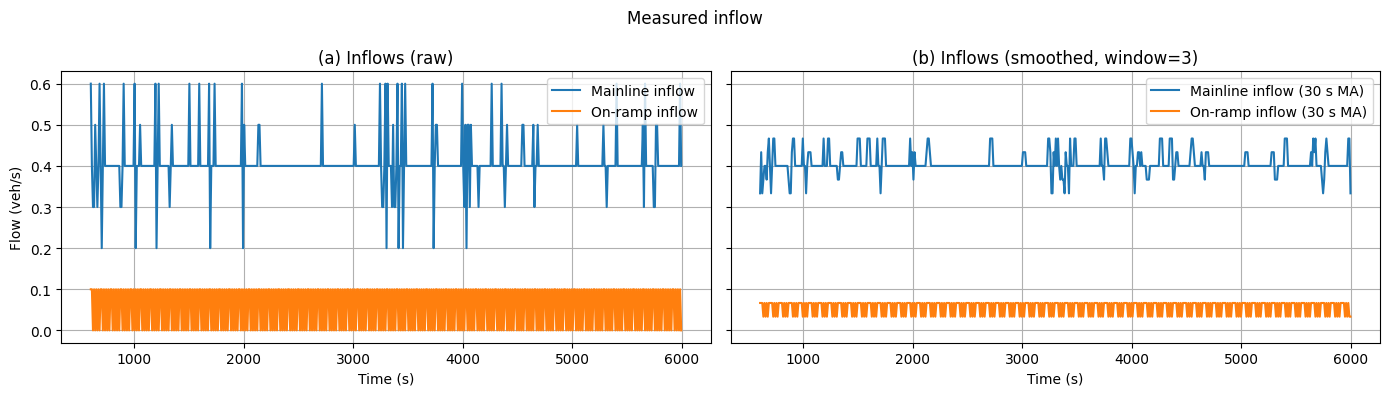

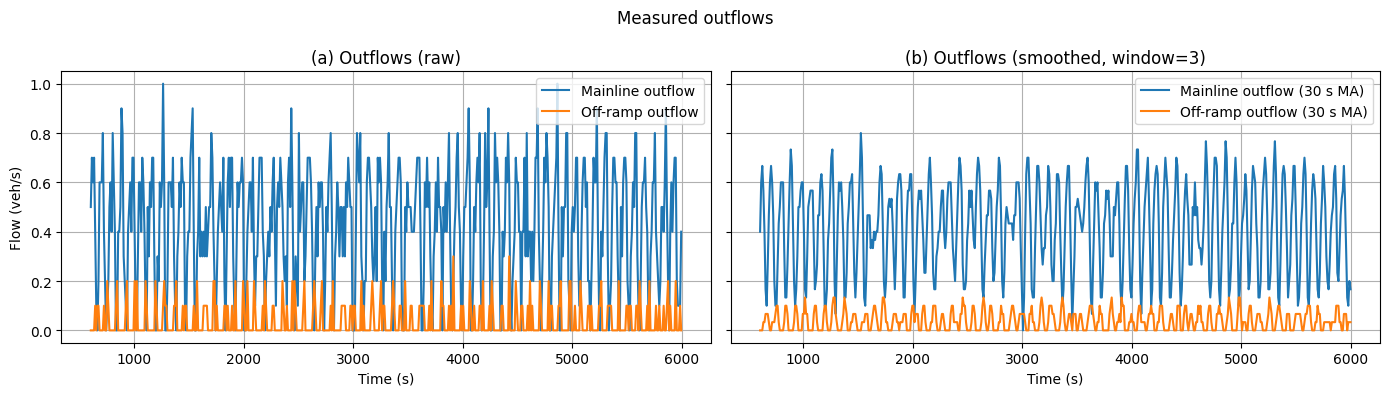

Average mainline inflow (veh/h): 1464.0
Average on-ramp inflow (veh/h): 200.0
Average mainline outflow (veh/h): 1511.3333333333335
Average off-ramp outflow (veh/h): 145.33333333333334


In [47]:
import xml.etree.ElementTree as ET
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# USER SETTINGS
# =========================================================
MAIN_IN_PATH  = "Heavy/Output-Default-Priority/main-in-detector.xml"
ON_RAMP_PATH  = "Heavy/Output-Default-Priority/on-ramp-detector.xml"
MAIN_OUT_PATH = "Heavy/Output-Default-Priority/main-out-detector.xml"
OFF_OUT_PATH  = "Heavy/Output-Default-Priority/off-ramp-detector.xml"

WARMUP_SEC = 600.0

# If detector interval is 10s, WINDOW=3 => ~30s MA
WINDOW = 3

# =========================================================
# 1) Read SUMO induction-loop XML (multiple detector IDs)
# =========================================================
def read_loop_file_by_id(xml_path):
    """
    Reads SUMO induction-loop output XML.
    Handles multiple detectors writing to the same file.

    Returns:
        dict {detector_id: (times_mid, flows_veh_per_s)}
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    acc = defaultdict(list)

    for interval in root.iter("interval"):
        det_id = interval.get("id", "UNKNOWN")

        begin = float(interval.get("begin"))
        end   = float(interval.get("end"))
        dt = end - begin
        if dt <= 0:
            continue

        nveh = interval.get("nVehContrib")
        if nveh is None:
            nveh = interval.get("entered", "0")
        nveh = float(nveh)

        t_mid = 0.5 * (begin + end)
        flow = nveh / dt  # veh/s

        acc[det_id].append((t_mid, flow))

    out = {}
    for det_id, rows in acc.items():
        rows.sort(key=lambda x: x[0])
        out[det_id] = ([r[0] for r in rows], [r[1] for r in rows])

    return out


# =========================================================
# 2) Sum flows across detectors (lanes)
# =========================================================
def sum_series(series_list):
    totals = defaultdict(float)
    for times, flows in series_list:
        for t, f in zip(times, flows):
            totals[round(t, 6)] += f

    times_out = sorted(totals.keys())
    flows_out = [totals[t] for t in times_out]
    return times_out, flows_out


def sum_detectors(det_dict):
    series = [det_dict[k] for k in det_dict.keys()]
    return sum_series(series)


# =========================================================
# 3) Moving average (for smooth plots)
# =========================================================
def moving_average(x, window):
    if window is None or window <= 1:
        return np.asarray(x, dtype=float)
    return np.convolve(np.asarray(x, dtype=float), np.ones(window) / window, mode="same")


# =========================================================
# 4) Warmup filter
# =========================================================
def apply_warmup(times, flows, warmup_sec):
    t2, f2 = [], []
    for t, f in zip(times, flows):
        if t >= warmup_sec:
            t2.append(t)
            f2.append(f)
    return t2, f2


# =========================================================
# 5) Load detector data
# =========================================================
main_in_dict  = read_loop_file_by_id(MAIN_IN_PATH)
on_ramp_dict  = read_loop_file_by_id(ON_RAMP_PATH)
main_out_dict = read_loop_file_by_id(MAIN_OUT_PATH)
off_out_dict  = read_loop_file_by_id(OFF_OUT_PATH)

print("Main-in detectors:", list(main_in_dict.keys()))
print("On-ramp detectors:", list(on_ramp_dict.keys()))
print("Main-out detectors:", list(main_out_dict.keys()))
print("Off-out detectors:", list(off_out_dict.keys()))

# Sum lanes
main_in_t, main_in_q   = sum_detectors(main_in_dict)
on_ramp_t, on_ramp_q   = sum_detectors(on_ramp_dict)
main_out_t, main_out_q = sum_detectors(main_out_dict)
off_out_t, off_out_q   = sum_detectors(off_out_dict)

# Apply warmup removal
main_in_t, main_in_q   = apply_warmup(main_in_t, main_in_q, WARMUP_SEC)
on_ramp_t, on_ramp_q   = apply_warmup(on_ramp_t, on_ramp_q, WARMUP_SEC)
main_out_t, main_out_q = apply_warmup(main_out_t, main_out_q, WARMUP_SEC)
off_out_t, off_out_q   = apply_warmup(off_out_t, off_out_q, WARMUP_SEC)

# =========================================================
# 6) RAW vs SMOOTHED side-by-side plots
# =========================================================

# ---------- INFLOWS ----------
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# RAW
axes[0].plot(main_in_t, main_in_q, label="Mainline inflow")
axes[0].plot(on_ramp_t, on_ramp_q, label="On-ramp inflow")
axes[0].set_title("(a) Inflows (raw)")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Flow (veh/s)")
axes[0].grid(True)
axes[0].legend(loc="upper right")

# SMOOTHED
axes[1].plot(main_in_t, moving_average(main_in_q, WINDOW), label=f"Mainline inflow (30 s MA)")
axes[1].plot(on_ramp_t, moving_average(on_ramp_q, WINDOW), label=f"On-ramp inflow (30 s MA)")
axes[1].set_title(f"(b) Inflows (smoothed, window={WINDOW})")
axes[1].set_xlabel("Time (s)")
axes[1].grid(True)
axes[1].legend(loc="upper right")

plt.suptitle(f"Measured inflow")
plt.tight_layout()
plt.show()

# ---------- OUTFLOWS ----------
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# RAW
axes[0].plot(main_out_t, main_out_q, label="Mainline outflow")
axes[0].plot(off_out_t, off_out_q, label="Off-ramp outflow")
axes[0].set_title("(a) Outflows (raw)")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Flow (veh/s)")
axes[0].grid(True)
axes[0].legend(loc="upper right")

# SMOOTHED
axes[1].plot(main_out_t, moving_average(main_out_q, WINDOW), label=f"Mainline outflow (30 s MA)")
axes[1].plot(off_out_t, moving_average(off_out_q, WINDOW), label=f"Off-ramp outflow (30 s MA)")
axes[1].set_title(f"(b) Outflows (smoothed, window={WINDOW})")
axes[1].set_xlabel("Time (s)")
axes[1].grid(True)
axes[1].legend(loc="upper right")

plt.suptitle(f"Measured outflows")
plt.tight_layout()
plt.show()

# =========================================================
# 7) Print average realized flows (veh/h) after warmup
# =========================================================
print("Average mainline inflow (veh/h):", np.mean(main_in_q) * 3600)
print("Average on-ramp inflow (veh/h):", np.mean(on_ramp_q) * 3600)
print("Average mainline outflow (veh/h):", np.mean(main_out_q) * 3600)
print("Average off-ramp outflow (veh/h):", np.mean(off_out_q) * 3600)


Main-in detectors: ['main_in_0', 'main_in_1', 'main_in_2']
On-ramp detectors: ['on_ramp']
Main-out detectors: ['final_out_0', 'final_out_1', 'final_out_2']
Off-out detectors: ['off_out']


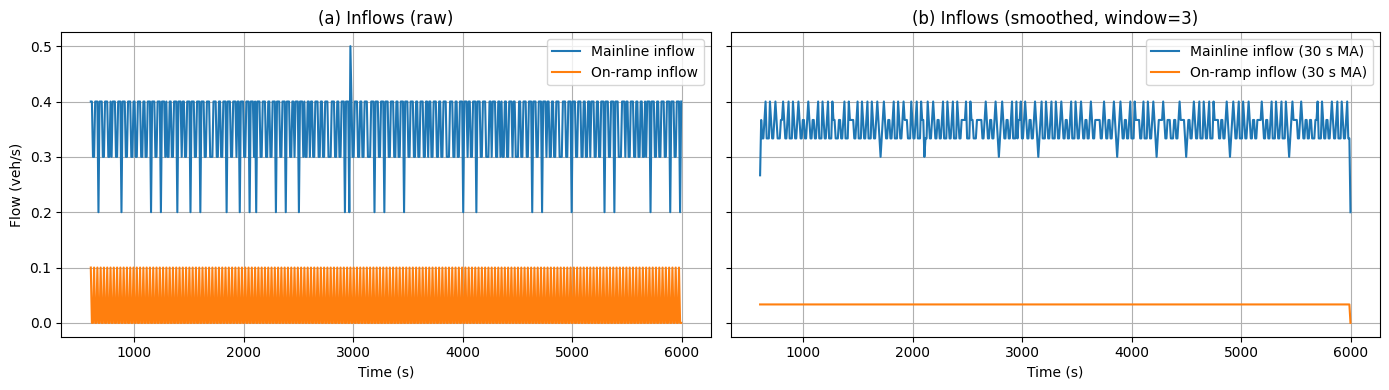

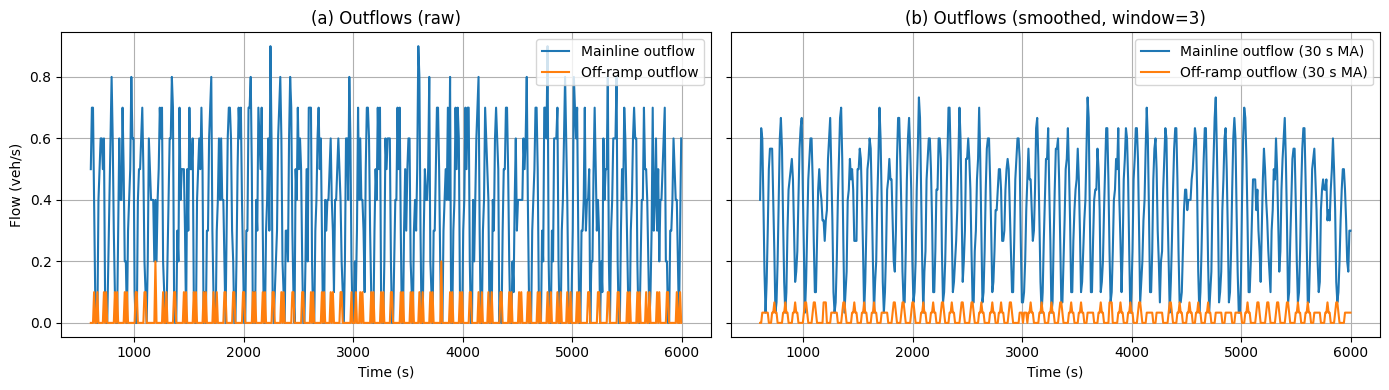

Average mainline inflow (veh/h): 1280.0
Average on-ramp inflow (veh/h): 120.0
Average mainline outflow (veh/h): 1318.6666666666667
Average off-ramp outflow (veh/h): 80.00000000000001


In [48]:
import xml.etree.ElementTree as ET
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# USER SETTINGS
# =========================================================
MAIN_IN_PATH  = "Medium/Output-Default-Priority/main-in-detector.xml"
ON_RAMP_PATH  = "Medium/Output-Default-Priority/on-ramp-detector.xml"
MAIN_OUT_PATH = "Medium/Output-Default-Priority/main-out-detector.xml"
OFF_OUT_PATH  = "Medium/Output-Default-Priority/off-ramp-detector.xml"

WARMUP_SEC = 600.0

# If detector interval is 10s, WINDOW=3 => ~30s MA
WINDOW = 3

# =========================================================
# 1) Read SUMO induction-loop XML (multiple detector IDs)
# =========================================================
def read_loop_file_by_id(xml_path):
    """
    Reads SUMO induction-loop output XML.
    Handles multiple detectors writing to the same file.

    Returns:
        dict {detector_id: (times_mid, flows_veh_per_s)}
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    acc = defaultdict(list)

    for interval in root.iter("interval"):
        det_id = interval.get("id", "UNKNOWN")

        begin = float(interval.get("begin"))
        end   = float(interval.get("end"))
        dt = end - begin
        if dt <= 0:
            continue

        nveh = interval.get("nVehContrib")
        if nveh is None:
            nveh = interval.get("entered", "0")
        nveh = float(nveh)

        t_mid = 0.5 * (begin + end)
        flow = nveh / dt  # veh/s

        acc[det_id].append((t_mid, flow))

    out = {}
    for det_id, rows in acc.items():
        rows.sort(key=lambda x: x[0])
        out[det_id] = ([r[0] for r in rows], [r[1] for r in rows])

    return out


# =========================================================
# 2) Sum flows across detectors (lanes)
# =========================================================
def sum_series(series_list):
    totals = defaultdict(float)
    for times, flows in series_list:
        for t, f in zip(times, flows):
            totals[round(t, 6)] += f

    times_out = sorted(totals.keys())
    flows_out = [totals[t] for t in times_out]
    return times_out, flows_out


def sum_detectors(det_dict):
    series = [det_dict[k] for k in det_dict.keys()]
    return sum_series(series)


# =========================================================
# 3) Moving average (for smooth plots)
# =========================================================
def moving_average(x, window):
    if window is None or window <= 1:
        return np.asarray(x, dtype=float)
    return np.convolve(np.asarray(x, dtype=float), np.ones(window) / window, mode="same")


# =========================================================
# 4) Warmup filter
# =========================================================
def apply_warmup(times, flows, warmup_sec):
    t2, f2 = [], []
    for t, f in zip(times, flows):
        if t >= warmup_sec:
            t2.append(t)
            f2.append(f)
    return t2, f2


# =========================================================
# 5) Load detector data
# =========================================================
main_in_dict  = read_loop_file_by_id(MAIN_IN_PATH)
on_ramp_dict  = read_loop_file_by_id(ON_RAMP_PATH)
main_out_dict = read_loop_file_by_id(MAIN_OUT_PATH)
off_out_dict  = read_loop_file_by_id(OFF_OUT_PATH)

print("Main-in detectors:", list(main_in_dict.keys()))
print("On-ramp detectors:", list(on_ramp_dict.keys()))
print("Main-out detectors:", list(main_out_dict.keys()))
print("Off-out detectors:", list(off_out_dict.keys()))

# Sum lanes
main_in_t, main_in_q   = sum_detectors(main_in_dict)
on_ramp_t, on_ramp_q   = sum_detectors(on_ramp_dict)
main_out_t, main_out_q = sum_detectors(main_out_dict)
off_out_t, off_out_q   = sum_detectors(off_out_dict)

# Apply warmup removal
main_in_t, main_in_q   = apply_warmup(main_in_t, main_in_q, WARMUP_SEC)
on_ramp_t, on_ramp_q   = apply_warmup(on_ramp_t, on_ramp_q, WARMUP_SEC)
main_out_t, main_out_q = apply_warmup(main_out_t, main_out_q, WARMUP_SEC)
off_out_t, off_out_q   = apply_warmup(off_out_t, off_out_q, WARMUP_SEC)

# =========================================================
# 6) RAW vs SMOOTHED side-by-side plots
# =========================================================

# ---------- INFLOWS ----------
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# RAW
axes[0].plot(main_in_t, main_in_q, label="Mainline inflow")
axes[0].plot(on_ramp_t, on_ramp_q, label="On-ramp inflow")
axes[0].set_title("(a) Inflows (raw)")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Flow (veh/s)")
axes[0].grid(True)
axes[0].legend(loc="upper right")

# SMOOTHED
axes[1].plot(main_in_t, moving_average(main_in_q, WINDOW), label=f"Mainline inflow (30 s MA)")
axes[1].plot(on_ramp_t, moving_average(on_ramp_q, WINDOW), label=f"On-ramp inflow (30 s MA)")
axes[1].set_title(f"(b) Inflows (smoothed, window={WINDOW})")
axes[1].set_xlabel("Time (s)")
axes[1].grid(True)
axes[1].legend(loc="upper right")

# plt.suptitle(f"Measured inflows")
plt.tight_layout()
plt.show()

# ---------- OUTFLOWS ----------
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# RAW
axes[0].plot(main_out_t, main_out_q, label="Mainline outflow")
axes[0].plot(off_out_t, off_out_q, label="Off-ramp outflow")
axes[0].set_title("(a) Outflows (raw)")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Flow (veh/s)")
axes[0].grid(True)
axes[0].legend(loc="upper right")

# SMOOTHED
axes[1].plot(main_out_t, moving_average(main_out_q, WINDOW), label=f"Mainline outflow (30 s MA)")
axes[1].plot(off_out_t, moving_average(off_out_q, WINDOW), label=f"Off-ramp outflow (30 s MA)")
axes[1].set_title(f"(b) Outflows (smoothed, window={WINDOW})")
axes[1].set_xlabel("Time (s)")
axes[1].grid(True)
axes[1].legend(loc="upper right")

# plt.suptitle(f"Measured outflows")
plt.tight_layout()
plt.show()

# =========================================================
# 7) Print average realized flows (veh/h) after warmup
# =========================================================
print("Average mainline inflow (veh/h):", np.mean(main_in_q) * 3600)
print("Average on-ramp inflow (veh/h):", np.mean(on_ramp_q) * 3600)
print("Average mainline outflow (veh/h):", np.mean(main_out_q) * 3600)
print("Average off-ramp outflow (veh/h):", np.mean(off_out_q) * 3600)


Main-in detectors: ['main_in_0', 'main_in_1', 'main_in_2']
On-ramp detectors: ['on_ramp']
Main-out detectors: ['final_out_0', 'final_out_1', 'final_out_2']
Off-out detectors: ['off_out']


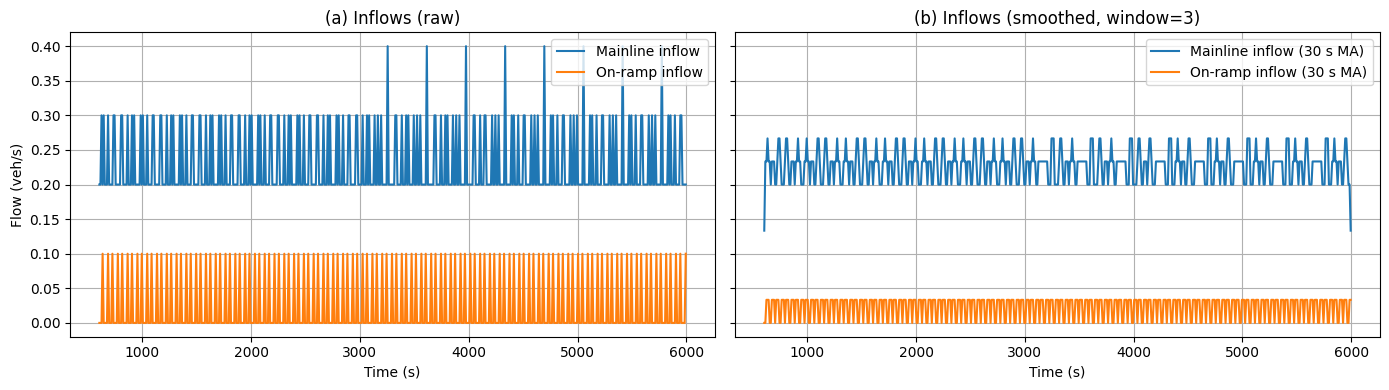

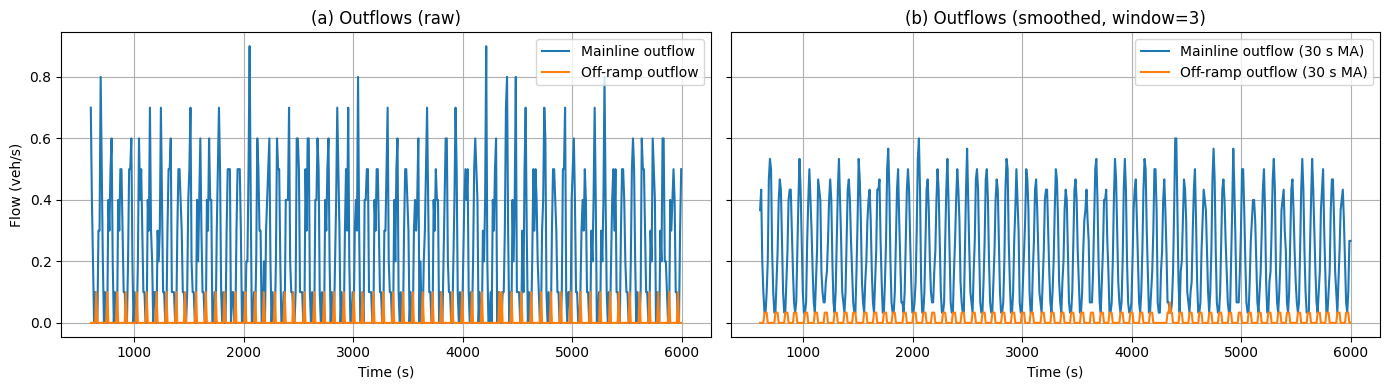

Average mainline inflow (veh/h): 820.0
Average on-ramp inflow (veh/h): 80.00000000000001
Average mainline outflow (veh/h): 860.6666666666666
Average off-ramp outflow (veh/h): 40.0


In [44]:
import xml.etree.ElementTree as ET
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# USER SETTINGS
# =========================================================
MAIN_IN_PATH  = "Light/Output-Default-Priority/main-in-detector.xml"
ON_RAMP_PATH  = "Light/Output-Default-Priority/on-ramp-detector.xml"
MAIN_OUT_PATH = "Light/Output-Default-Priority/main-out-detector.xml"
OFF_OUT_PATH  = "Light/Output-Default-Priority/off-ramp-detector.xml"

WARMUP_SEC = 600.0

# If detector interval is 10s, WINDOW=3 => ~30s MA
WINDOW = 3

# =========================================================
# 1) Read SUMO induction-loop XML (multiple detector IDs)
# =========================================================
def read_loop_file_by_id(xml_path):
    """
    Reads SUMO induction-loop output XML.
    Handles multiple detectors writing to the same file.

    Returns:
        dict {detector_id: (times_mid, flows_veh_per_s)}
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    acc = defaultdict(list)

    for interval in root.iter("interval"):
        det_id = interval.get("id", "UNKNOWN")

        begin = float(interval.get("begin"))
        end   = float(interval.get("end"))
        dt = end - begin
        if dt <= 0:
            continue

        nveh = interval.get("nVehContrib")
        if nveh is None:
            nveh = interval.get("entered", "0")
        nveh = float(nveh)

        t_mid = 0.5 * (begin + end)
        flow = nveh / dt  # veh/s

        acc[det_id].append((t_mid, flow))

    out = {}
    for det_id, rows in acc.items():
        rows.sort(key=lambda x: x[0])
        out[det_id] = ([r[0] for r in rows], [r[1] for r in rows])

    return out


# =========================================================
# 2) Sum flows across detectors (lanes)
# =========================================================
def sum_series(series_list):
    totals = defaultdict(float)
    for times, flows in series_list:
        for t, f in zip(times, flows):
            totals[round(t, 6)] += f

    times_out = sorted(totals.keys())
    flows_out = [totals[t] for t in times_out]
    return times_out, flows_out


def sum_detectors(det_dict):
    series = [det_dict[k] for k in det_dict.keys()]
    return sum_series(series)


# =========================================================
# 3) Moving average (for smooth plots)
# =========================================================
def moving_average(x, window):
    if window is None or window <= 1:
        return np.asarray(x, dtype=float)
    return np.convolve(np.asarray(x, dtype=float), np.ones(window) / window, mode="same")


# =========================================================
# 4) Warmup filter
# =========================================================
def apply_warmup(times, flows, warmup_sec):
    t2, f2 = [], []
    for t, f in zip(times, flows):
        if t >= warmup_sec:
            t2.append(t)
            f2.append(f)
    return t2, f2


# =========================================================
# 5) Load detector data
# =========================================================
main_in_dict  = read_loop_file_by_id(MAIN_IN_PATH)
on_ramp_dict  = read_loop_file_by_id(ON_RAMP_PATH)
main_out_dict = read_loop_file_by_id(MAIN_OUT_PATH)
off_out_dict  = read_loop_file_by_id(OFF_OUT_PATH)

print("Main-in detectors:", list(main_in_dict.keys()))
print("On-ramp detectors:", list(on_ramp_dict.keys()))
print("Main-out detectors:", list(main_out_dict.keys()))
print("Off-out detectors:", list(off_out_dict.keys()))

# Sum lanes
main_in_t, main_in_q   = sum_detectors(main_in_dict)
on_ramp_t, on_ramp_q   = sum_detectors(on_ramp_dict)
main_out_t, main_out_q = sum_detectors(main_out_dict)
off_out_t, off_out_q   = sum_detectors(off_out_dict)

# Apply warmup removal
main_in_t, main_in_q   = apply_warmup(main_in_t, main_in_q, WARMUP_SEC)
on_ramp_t, on_ramp_q   = apply_warmup(on_ramp_t, on_ramp_q, WARMUP_SEC)
main_out_t, main_out_q = apply_warmup(main_out_t, main_out_q, WARMUP_SEC)
off_out_t, off_out_q   = apply_warmup(off_out_t, off_out_q, WARMUP_SEC)

# =========================================================
# 6) RAW vs SMOOTHED side-by-side plots
# =========================================================

# ---------- INFLOWS ----------
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# RAW
axes[0].plot(main_in_t, main_in_q, label="Mainline inflow")
axes[0].plot(on_ramp_t, on_ramp_q, label="On-ramp inflow")
axes[0].set_title("(a) Inflows (raw)")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Flow (veh/s)")
axes[0].grid(True)
axes[0].legend(loc="upper right")

# SMOOTHED
axes[1].plot(main_in_t, moving_average(main_in_q, WINDOW), label=f"Mainline inflow (30 s MA)")
axes[1].plot(on_ramp_t, moving_average(on_ramp_q, WINDOW), label=f"On-ramp inflow (30 s MA)")
axes[1].set_title(f"(b) Inflows (smoothed, window={WINDOW})")
axes[1].set_xlabel("Time (s)")
axes[1].grid(True)
axes[1].legend(loc="upper right")

# plt.suptitle(f"Measured inflows")
plt.tight_layout()
plt.show()

# ---------- OUTFLOWS ----------
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# RAW
axes[0].plot(main_out_t, main_out_q, label="Mainline outflow")
axes[0].plot(off_out_t, off_out_q, label="Off-ramp outflow")
axes[0].set_title("(a) Outflows (raw)")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Flow (veh/s)")
axes[0].grid(True)
axes[0].legend(loc="upper right")

# SMOOTHED
axes[1].plot(main_out_t, moving_average(main_out_q, WINDOW), label=f"Mainline outflow (30 s MA)")
axes[1].plot(off_out_t, moving_average(off_out_q, WINDOW), label=f"Off-ramp outflow (30 s MA)")
axes[1].set_title(f"(b) Outflows (smoothed, window={WINDOW})")
axes[1].set_xlabel("Time (s)")
axes[1].grid(True)
axes[1].legend(loc="upper right")

# plt.suptitle(f"Measured outflows")
plt.tight_layout()
plt.show()

# =========================================================
# 7) Print average realized flows (veh/h) after warmup
# =========================================================
print("Average mainline inflow (veh/h):", np.mean(main_in_q) * 3600)
print("Average on-ramp inflow (veh/h):", np.mean(on_ramp_q) * 3600)
print("Average mainline outflow (veh/h):", np.mean(main_out_q) * 3600)
print("Average off-ramp outflow (veh/h):", np.mean(off_out_q) * 3600)


Loaded scenarios: ['Light', 'Medium', 'Heavy']
Light Total CO2 (g): 8940601504.830002 Total NOx (g): 3368739.04
Medium Total CO2 (g): 14440030844.61 Total NOx (g): 5397101.01
Heavy Total CO2 (g): 17765062365.010002 Total NOx (g): 6629966.2299999995


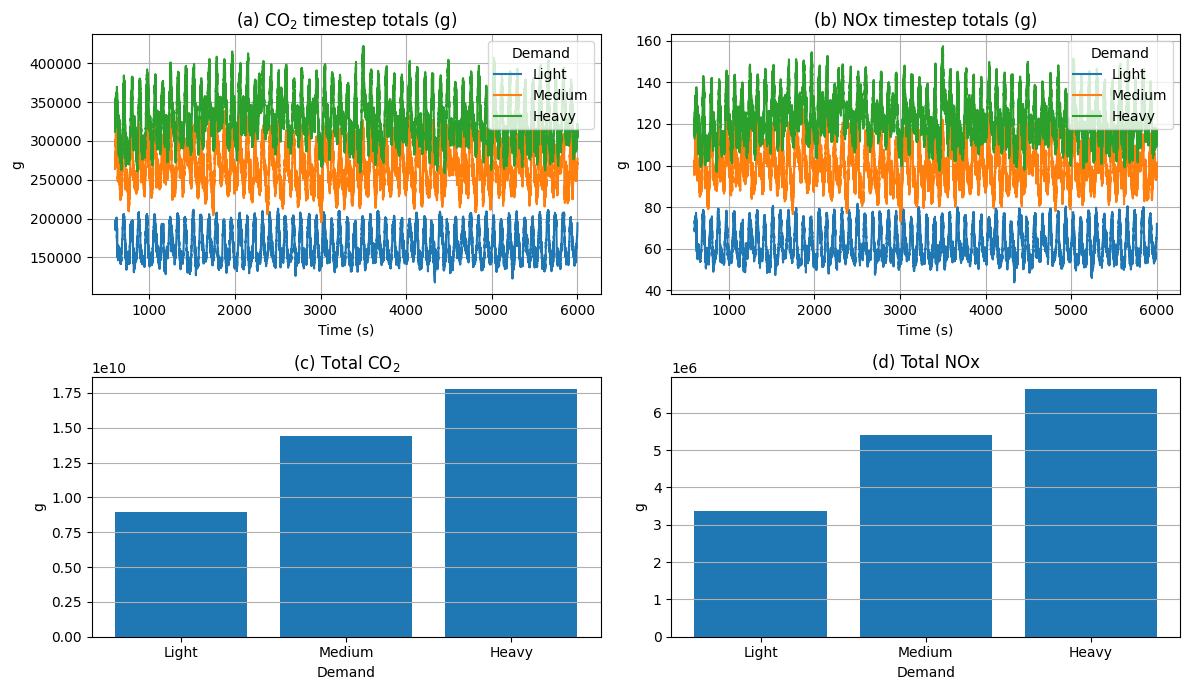

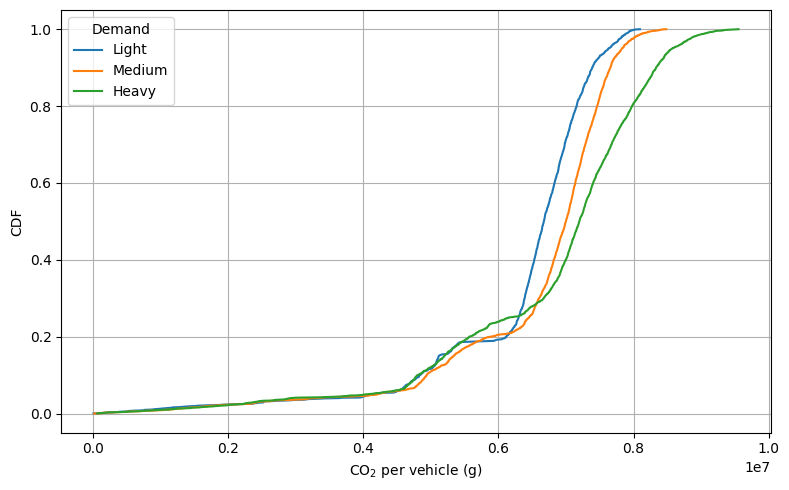

In [50]:
import os
import xml.etree.ElementTree as ET
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# SETTINGS (EDIT THESE)
# =========================================================
SCENARIOS = {
    "Light":  r"Light/Output-Default-Priority/emissions.xml",
    "Medium": r"Medium/Output-Default-Priority/emissions.xml",
    "Heavy":  r"Heavy/Output-Default-Priority/emissions.xml",
}

WARMUP_SEC = 600.0
CO2_KEY = "CO2"
NOX_KEY = "NOx"

# Optional: save figures
SAVE = False
EMISSIONS_FIG = "emissions_summary.png"
CDF_FIG = "per_vehicle_co2_cdf.png"

# =========================================================
# PARSING
# =========================================================
def safe_float(x, default=np.nan):
    try:
        return float(x)
    except Exception:
        return default


def parse_emissions_timeseries(emissions_xml, warmup_sec=0.0, co2_key="CO2", nox_key="NOx"):
    """
    Parses SUMO timestep-style emissions:
      <timestep time="...">
        <vehicle id="..." CO2="..." NOx="..." .../>
      </timestep>

    Returns:
      times, co2_step_total, nox_step_total, per_vehicle_co2_total
    """
    if not os.path.exists(emissions_xml):
        raise FileNotFoundError(f"Missing file: {emissions_xml}")

    co2_by_time = defaultdict(float)
    nox_by_time = defaultdict(float)
    co2_by_vehicle = defaultdict(float)

    has_timestep = False
    current_time = None

    for event, elem in ET.iterparse(emissions_xml, events=("start", "end")):
        if event == "start" and elem.tag == "timestep":
            has_timestep = True
            current_time = safe_float(elem.get("time"))
            continue

        if event == "end" and elem.tag == "vehicle":
            if current_time is None or not np.isfinite(current_time) or current_time < warmup_sec:
                elem.clear()
                continue

            vid = elem.get("id", None)
            co2 = safe_float(elem.get(co2_key))
            nox = safe_float(elem.get(nox_key))

            if np.isfinite(co2):
                co2_by_time[current_time] += co2
                if vid is not None:
                    co2_by_vehicle[vid] += co2

            if np.isfinite(nox):
                nox_by_time[current_time] += nox

            elem.clear()
            continue

        if event == "end" and elem.tag == "timestep":
            current_time = None
            elem.clear()

    if not has_timestep:
        raise ValueError(
            "No <timestep> blocks found. This code expects timestep emissions output."
        )

    times = sorted(co2_by_time.keys() | nox_by_time.keys())
    co2_series = np.array([co2_by_time[t] for t in times], dtype=float)
    nox_series = np.array([nox_by_time[t] for t in times], dtype=float)

    per_vehicle = np.array(list(co2_by_vehicle.values()), dtype=float)
    per_vehicle = per_vehicle[np.isfinite(per_vehicle)]

    return times, co2_series, nox_series, per_vehicle


def ecdf(x):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.array([]), np.array([])
    xs = np.sort(x)
    ys = np.arange(1, xs.size + 1) / xs.size
    return xs, ys


# =========================================================
# LOAD ALL SCENARIOS
# =========================================================
data = {}
for name, path in SCENARIOS.items():
    t, co2_step, nox_step, co2_perveh = parse_emissions_timeseries(
        path, warmup_sec=WARMUP_SEC, co2_key=CO2_KEY, nox_key=NOX_KEY
    )
    data[name] = {
        "t": np.array(t, dtype=float),
        "co2_step": np.array(co2_step, dtype=float),
        "nox_step": np.array(nox_step, dtype=float),
        "co2_total": float(np.nansum(co2_step)),
        "nox_total": float(np.nansum(nox_step)),
        "co2_perveh": co2_perveh,
    }

order = ["Light", "Medium", "Heavy"]

print("Loaded scenarios:", list(data.keys()))
for k in order:
    print(k, "Total CO2 (g):", data[k]["co2_total"], "Total NOx (g):", data[k]["nox_total"])


# =========================================================
# FIGURE 1: EMISSIONS ONLY (2x2)
# =========================================================
fig1, axes = plt.subplots(2, 2, figsize=(12, 7))
ax_a, ax_b = axes[0, 0], axes[0, 1]
ax_c, ax_d = axes[1, 0], axes[1, 1]

# (a) CO2 timestep totals
for name in order:
    ax_a.plot(data[name]["t"], data[name]["co2_step"], label=name)
ax_a.set_title("(a) CO$_2$ timestep totals (g)")
ax_a.set_xlabel("Time (s)")
ax_a.set_ylabel("g")
ax_a.grid(True)
ax_a.legend(title="Demand")

# (b) NOx timestep totals
for name in order:
    ax_b.plot(data[name]["t"], data[name]["nox_step"], label=name)
ax_b.set_title("(b) NOx timestep totals (g)")
ax_b.set_xlabel("Time (s)")
ax_b.set_ylabel("g")
ax_b.grid(True)
ax_b.legend(title="Demand")

# (c) Total CO2 bars
tot_co2 = [data[name]["co2_total"] for name in order]
ax_c.bar(order, tot_co2)
ax_c.set_title("(c) Total CO$_2$")
ax_c.set_xlabel("Demand")
ax_c.set_ylabel("g")
ax_c.grid(True, axis="y")

# (d) Total NOx bars
tot_nox = [data[name]["nox_total"] for name in order]
ax_d.bar(order, tot_nox)
ax_d.set_title("(d) Total NOx")
ax_d.set_xlabel("Demand")
ax_d.set_ylabel("g")
ax_d.grid(True, axis="y")

# fig1.suptitle(f"Emissions summary (warmup removed: first {int(WARMUP_SEC)} s)", y=1.02)
fig1.tight_layout()
if SAVE:
    fig1.savefig(EMISSIONS_FIG, dpi=200)
plt.show()


# =========================================================
# FIGURE 2: PER-VEHICLE CO2 CDF ONLY
# =========================================================
fig2 = plt.figure(figsize=(8, 5))
ax = fig2.add_subplot(1, 1, 1)

for name in order:
    xs, ys = ecdf(data[name]["co2_perveh"])
    if xs.size > 0:
        ax.plot(xs, ys, label=name)

# ax.set_title("CDF of per-vehicle CO$_2$")
ax.set_xlabel("CO$_2$ per vehicle (g)")
ax.set_ylabel("CDF")
ax.grid(True)
ax.legend(title="Demand")

fig2.tight_layout()
if SAVE:
    fig2.savefig(CDF_FIG, dpi=200)
plt.show()


In [59]:
import os
import math
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt

# -------- Defaults (no terminal, no args) --------
SCENARIOS = {
    "Light": {
        "NET_PATH": "Light/Changed-priority-network.net.xml",
        "ROU_PATH": os.path.join("Light", "demand_low.rou.xml"),
        "FCD_PATH": os.path.join("Light/Output-Changed-Priority", "fcd.xml"),
    },
    "Medium": {
        "NET_PATH": "Medium/Changed-priority-network.net.xml",
        "ROU_PATH": os.path.join("Medium", "demand_mid.rou.xml"),
        "FCD_PATH": os.path.join("Medium/Output-Changed-Priority", "fcd.xml"),
    },
    "Heavy": {
        "NET_PATH": "Heavy/Changed-priority-network.net.xml",
        "ROU_PATH": os.path.join("Heavy", "demand_high.rou.xml"),
        "FCD_PATH": os.path.join("Heavy/Output-Changed-Priority", "fcd.xml"),
    },
}

OUT_PATH = "ts_mainline_changed_p_occupancy_low_mid_high.png"

ROUTE_ID = "r_main"          # mainline route id in .rou.xml
DIST_BIN_M = 20.0            # distance bin size (meters)
VEH_LEN_M = 5.0              # assumed vehicle length (meters) for occupancy
MAX_ROWS = None              # e.g., 2000 to limit plotting; None = all
# -----------------------------------------------


def must_exist(path: str, label: str):
    if not os.path.exists(path):
        raise FileNotFoundError(f"{label} not found: {path}")


def parse_mainline_edges_from_rou(rou_path: str, route_id: str) -> list[str]:
    tree = ET.parse(rou_path)
    root = tree.getroot()
    for r in root.findall("route"):
        if r.get("id") == route_id:
            edges = (r.get("edges") or "").strip()
            if not edges:
                raise ValueError(f"Route '{route_id}' found but edges is empty.")
            return edges.split()
    raise ValueError(f"Route id '{route_id}' not found in {rou_path}.")


def parse_net_lane_edge_lengths_and_lanes(net_path: str):
    """
    Returns:
      lane_to_edge: laneId -> edgeId
      edge_len: edgeId -> length (m)
      edge_lanes: edgeId -> lane count
    """
    tree = ET.parse(net_path)
    root = tree.getroot()

    lane_to_edge = {}
    edge_len = {}
    edge_lanes = {}

    for edge in root.findall("edge"):
        edge_id = edge.get("id")
        if edge_id is None:
            continue
        if edge.get("function") == "internal":
            continue

        lanes = edge.findall("lane")
        if not lanes:
            continue

        edge_lanes[edge_id] = len(lanes)

        for ln in lanes:
            lid = ln.get("id")
            llen = ln.get("length")
            if lid is None or llen is None:
                continue
            lane_to_edge[lid] = edge_id
            if edge_id not in edge_len:
                edge_len[edge_id] = float(llen)

    return lane_to_edge, edge_len, edge_lanes


def build_prefix(main_edges: list[str], edge_len: dict[str, float]) -> tuple[dict[str, float], float]:
    prefix = {}
    s = 0.0
    for e in main_edges:
        if e not in edge_len:
            raise ValueError(
                f"Edge '{e}' from route not found in net. "
                f"Your rou edges must match the net edges."
            )
        prefix[e] = s
        s += edge_len[e]
    return prefix, s


def weighted_avg_lanes(main_edges: list[str], edge_len: dict[str, float], edge_lanes: dict[str, int]) -> float:
    num = 0.0
    den = 0.0
    for e in main_edges:
        L = edge_len[e]
        nlan = edge_lanes.get(e, 1)
        num += L * nlan
        den += L
    return num / max(den, 1e-9)


def iter_fcd_timesteps(fcd_path: str):
    """
    Yields (time, list_of_vehicle_dicts)
    Each vehicle dict contains lane, pos.
    """
    context = ET.iterparse(fcd_path, events=("start", "end"))
    _, root = next(context)

    current_time = None
    vehicles = []

    for event, elem in context:
        if event == "start" and elem.tag == "timestep":
            t = elem.get("time")
            current_time = float(t) if t is not None else None
            vehicles = []

        elif event == "end" and elem.tag == "vehicle":
            lane = elem.get("lane")
            pos = elem.get("pos")
            if lane is not None and pos is not None:
                vehicles.append({"lane": lane, "pos": float(pos)})
            elem.clear()

        elif event == "end" and elem.tag == "timestep":
            if current_time is not None:
                yield current_time, vehicles
            elem.clear()
            root.clear()


def compute_timespace_occupancy(net_path, rou_path, fcd_path):
    must_exist(net_path, "NET")
    must_exist(rou_path, "ROU")
    must_exist(fcd_path, "FCD")

    main_edges = parse_mainline_edges_from_rou(rou_path, ROUTE_ID)
    lane_to_edge, edge_len, edge_lanes = parse_net_lane_edge_lengths_and_lanes(net_path)
    prefix, main_len_m = build_prefix(main_edges, edge_len)
    main_set = set(main_edges)

    nbins = int(math.ceil(main_len_m / DIST_BIN_M))
    lanes_norm = weighted_avg_lanes(main_edges, edge_len, edge_lanes)
    lanes_norm = max(1.0, lanes_norm)

    times = []
    rows = []

    for t, vehs in iter_fcd_timesteps(fcd_path):
        row_occ_len = np.zeros(nbins, dtype=np.float32)

        for v in vehs:
            edge_id = lane_to_edge.get(v["lane"])
            if edge_id is None or edge_id not in main_set:
                continue
            dist = prefix[edge_id] + v["pos"]
            if dist < 0 or dist >= main_len_m:
                continue
            j = int(dist // DIST_BIN_M)
            if 0 <= j < nbins:
                row_occ_len[j] += VEH_LEN_M

        row_occ = row_occ_len / (DIST_BIN_M * lanes_norm)
        row_occ = np.clip(row_occ, 0.0, 1.0)

        times.append(t)
        rows.append(row_occ)

        if MAX_ROWS is not None and len(rows) >= MAX_ROWS:
            break

    if not rows:
        raise RuntimeError(
            "No data collected from FCD for the mainline route. Check:\n"
            "1) FCD includes lane and pos\n"
            "2) ROUTE_ID matches your mainline route in the .rou.xml\n"
            "3) vehicles actually travel on that route"
        )

    M = np.vstack(rows)  # [T, D]
    miles = (np.arange(nbins + 1) * DIST_BIN_M) / 1609.344
    extent = [times[0], times[-1], miles[0], miles[-1]]

    meta = {
        "main_len_m": main_len_m,
        "nbins": nbins,
        "timesteps": M.shape[0],
        "lanes_norm": lanes_norm,
    }
    return M, extent, meta


def main():
    # Compute occupancy matrices for each scenario
    results = {}
    for name, paths in SCENARIOS.items():
        M, extent, meta = compute_timespace_occupancy(
            paths["NET_PATH"], paths["ROU_PATH"], paths["FCD_PATH"]
        )
        results[name] = (M, extent, meta)
        print(f"[{name}] length={meta['main_len_m']:.1f} m, bins={meta['nbins']}, "
              f"timesteps={meta['timesteps']}, lanes_norm≈{meta['lanes_norm']:.2f}")

    # Plot 3 subplots (low, mid, high) with one shared colorbar
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
    order = ["Light", "Medium", "Heavy"]

    ims = []
    for ax, name in zip(axes, order):
        M, extent, meta = results[name]
        im = ax.imshow(
            M.T,
            origin="lower",
            aspect="auto",
            extent=extent,
            interpolation="nearest",
            vmin=0.0,
            vmax=1.0,   # occupancy is clipped 0..1, so fix scale across plots
        )
        ims.append(im)
        ax.set_title(f"{name} demand")
        ax.set_xlabel("Time (s)")
        ax.grid(False)

    axes[0].set_ylabel("Mile")

    # Shared colorbar
    cbar = fig.colorbar(ims[-1], ax=axes, fraction=0.02, pad=0.02)
    cbar.set_label("Occupancy (0-1)")

    # plt.suptitle("Time–Space Diagram (Mainline)  Occupancy", y=1.02)
    plt.tight_layout()
    plt.savefig(OUT_PATH, dpi=200)
    plt.close()

    print(f"Saved: {OUT_PATH}")


if __name__ == "__main__":
    main()


[Light] length=3810.4 m, bins=191, timesteps=60000, lanes_norm≈3.22
[Medium] length=3810.4 m, bins=191, timesteps=60000, lanes_norm≈3.22
[Heavy] length=3810.4 m, bins=191, timesteps=60000, lanes_norm≈3.22


C:\Users\tasni\AppData\Local\Temp\ipykernel_5404\4084233615.py:247: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved: ts_mainline_changed_p_occupancy_low_mid_high.png


In [46]:
import os
import math
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt

# -------- Defaults --------
SCENARIOS = {
    "Light": {
        "NET_PATH": "Light/Changed-priority-network.net.xml",
        "ROU_PATH": os.path.join("Light", "demand_low.rou.xml"),
        "FCD_PATH": os.path.join("Light", "Output-Default-Priority", "fcd.xml"),
    },
    "Medium": {
        "NET_PATH": "Medium/Changed-priority-network.net.xml",
        "ROU_PATH": os.path.join("Medium", "demand_mid.rou.xml"),
        "FCD_PATH": os.path.join("Medium", "Output-Default-Priority", "fcd.xml"),
    },
    "Heavy": {
        "NET_PATH": "Heavy/Changed-priority-network.net.xml",
        "ROU_PATH": os.path.join("Heavy", "demand_high.rou.xml"),
        "FCD_PATH": os.path.join("Heavy", "Output-Default-Priority", "fcd.xml"),
    },
}

OUT_DIR = "ts_outputs"  # folder where images will be saved
ROUTE_ID = "r_main"
DIST_BIN_M = 20.0
VEH_LEN_M = 5.0
MAX_ROWS = None
# -------------------------


def must_exist(path: str, label: str):
    if not os.path.exists(path):
        raise FileNotFoundError(f"{label} not found: {path}")


def parse_mainline_edges_from_rou(rou_path: str, route_id: str) -> list[str]:
    tree = ET.parse(rou_path)
    root = tree.getroot()
    for r in root.findall("route"):
        if r.get("id") == route_id:
            edges = (r.get("edges") or "").strip()
            if not edges:
                raise ValueError(f"Route '{route_id}' found but edges is empty.")
            return edges.split()
    raise ValueError(f"Route id '{route_id}' not found in {rou_path}.")


def parse_net_lane_edge_lengths_and_lanes(net_path: str):
    tree = ET.parse(net_path)
    root = tree.getroot()

    lane_to_edge = {}
    edge_len = {}
    edge_lanes = {}

    for edge in root.findall("edge"):
        edge_id = edge.get("id")
        if edge_id is None:
            continue
        if edge.get("function") == "internal":
            continue

        lanes = edge.findall("lane")
        if not lanes:
            continue

        edge_lanes[edge_id] = len(lanes)

        for ln in lanes:
            lid = ln.get("id")
            llen = ln.get("length")
            if lid is None or llen is None:
                continue
            lane_to_edge[lid] = edge_id
            if edge_id not in edge_len:
                edge_len[edge_id] = float(llen)

    return lane_to_edge, edge_len, edge_lanes


def build_prefix(main_edges: list[str], edge_len: dict[str, float]):
    prefix = {}
    s = 0.0
    for e in main_edges:
        if e not in edge_len:
            raise ValueError(
                f"Edge '{e}' from route not found in net. "
                f"Your rou edges must match the net edges."
            )
        prefix[e] = s
        s += edge_len[e]
    return prefix, s


def weighted_avg_lanes(main_edges, edge_len, edge_lanes):
    num = 0.0
    den = 0.0
    for e in main_edges:
        L = edge_len[e]
        nlan = edge_lanes.get(e, 1)
        num += L * nlan
        den += L
    return num / max(den, 1e-9)


def iter_fcd_timesteps(fcd_path: str):
    context = ET.iterparse(fcd_path, events=("start", "end"))
    _, root = next(context)

    current_time = None
    vehicles = []

    for event, elem in context:
        if event == "start" and elem.tag == "timestep":
            t = elem.get("time")
            current_time = float(t) if t is not None else None
            vehicles = []

        elif event == "end" and elem.tag == "vehicle":
            lane = elem.get("lane")
            pos = elem.get("pos")
            if lane is not None and pos is not None:
                vehicles.append({"lane": lane, "pos": float(pos)})
            elem.clear()

        elif event == "end" and elem.tag == "timestep":
            if current_time is not None:
                yield current_time, vehicles
            elem.clear()
            root.clear()


def compute_timespace_occupancy(net_path, rou_path, fcd_path):
    must_exist(net_path, "NET")
    must_exist(rou_path, "ROU")
    must_exist(fcd_path, "FCD")

    main_edges = parse_mainline_edges_from_rou(rou_path, ROUTE_ID)
    lane_to_edge, edge_len, edge_lanes = parse_net_lane_edge_lengths_and_lanes(net_path)
    prefix, main_len_m = build_prefix(main_edges, edge_len)
    main_set = set(main_edges)

    nbins = int(math.ceil(main_len_m / DIST_BIN_M))
    lanes_norm = weighted_avg_lanes(main_edges, edge_len, edge_lanes)
    lanes_norm = max(1.0, lanes_norm)

    times = []
    rows = []

    for t, vehs in iter_fcd_timesteps(fcd_path):
        row_occ_len = np.zeros(nbins, dtype=np.float32)

        for v in vehs:
            edge_id = lane_to_edge.get(v["lane"])
            if edge_id is None or edge_id not in main_set:
                continue

            dist = prefix[edge_id] + v["pos"]
            if dist < 0 or dist >= main_len_m:
                continue

            j = int(dist // DIST_BIN_M)
            if 0 <= j < nbins:
                row_occ_len[j] += VEH_LEN_M

        row_occ = row_occ_len / (DIST_BIN_M * lanes_norm)
        row_occ = np.clip(row_occ, 0.0, 1.0)

        times.append(t)
        rows.append(row_occ)

        if MAX_ROWS is not None and len(rows) >= MAX_ROWS:
            break

    if not rows:
        raise RuntimeError("No data collected from FCD for the mainline route.")

    M = np.vstack(rows)
    miles = (np.arange(nbins + 1) * DIST_BIN_M) / 1609.344
    extent = [times[0], times[-1], miles[0], miles[-1]]

    return M, extent


def plot_and_save_single(name, M, extent, out_path):
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    im = ax.imshow(
        M.T,
        origin="lower",
        aspect="auto",
        extent=extent,
        interpolation="nearest",
        vmin=0.0,
        vmax=1.0,
    )
    # ax.set_title(f"{name} demand - Time–Space Occupancy")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Mile")

    cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
    cbar.set_label("Occupancy (0-1)")

    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()
    print(f"Saved: {out_path}")


def main():
    os.makedirs(OUT_DIR, exist_ok=True)

    for name, paths in SCENARIOS.items():
        M, extent = compute_timespace_occupancy(
            paths["NET_PATH"], paths["ROU_PATH"], paths["FCD_PATH"]
        )
        out_path = os.path.join(OUT_DIR, f"ts_mainline_occupancy_{name}.png")
        plot_and_save_single(name, M, extent, out_path)


if __name__ == "__main__":
    main()


Saved: ts_outputs\ts_mainline_occupancy_Light.png
Saved: ts_outputs\ts_mainline_occupancy_Medium.png
Saved: ts_outputs\ts_mainline_occupancy_Heavy.png


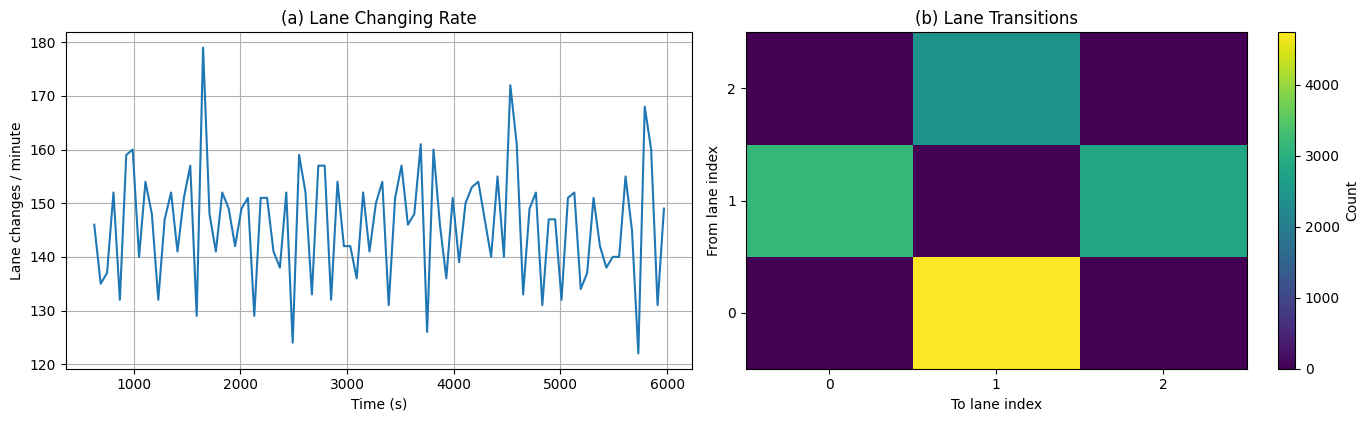

Transition matrix (from -> to) lanes 0/1/2:
[[   0 4739    0]
 [3151    0 2838]
 [   0 2432    0]]


In [56]:
import os
import re
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from collections import defaultdict

# =========================================================
# SETTINGS (EDIT THESE)
# =========================================================
FCD_PATH = "Heavy/Output-Default-Priority/fcd.xml"  # <-- set your fcd.xml
WARMUP_SEC = 600.0

BIN_SEC = 60.0          # lane changes per minute
MAX_TIME_SEC = None     # e.g., 5000; None = all
LANES_ALLOWED = {0, 1, 2}

# Your mainline edges (from route edges=...)
MAIN_EDGES_STR = """53187125 99457879 99457861 99457865 1447866124 99457871 1040199894
99457868 99457881 99457867 1040187307 1040187306 54582833 54582832 998964264
1040190012 54641968 54618319 726591114 726591113 726591150 726591149 103504797
103504792 103504816 103504815 50487000 518352630"""
MAIN_EDGES = set(MAIN_EDGES_STR.split())

# =========================================================


def must_exist(path: str):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")


def parse_lane_id(lane_id: str):
    """
    Expected SUMO lane id pattern: "<edgeId>_<laneIndex>"
    Returns (edge_id, lane_idx) or (None, None) if not parseable.
    """
    if lane_id is None:
        return None, None
    if "_" not in lane_id:
        return None, None
    edge, idx = lane_id.rsplit("_", 1)
    try:
        return edge, int(idx)
    except ValueError:
        return None, None


def iter_fcd(fcd_path: str):
    """
    Stream-parse SUMO FCD file.
    Yields (time, list_of_(veh_id, lane_id)).
    """
    context = ET.iterparse(fcd_path, events=("start", "end"))
    _, root = next(context)

    cur_t = None
    vehs = []

    for event, elem in context:
        if event == "start" and elem.tag == "timestep":
            t = elem.get("time")
            cur_t = float(t) if t is not None else None
            vehs = []

        elif event == "end" and elem.tag == "vehicle":
            vid = elem.get("id")
            lane = elem.get("lane")
            if cur_t is not None and vid is not None and lane is not None:
                vehs.append((vid, lane))
            elem.clear()

        elif event == "end" and elem.tag == "timestep":
            if cur_t is not None:
                yield cur_t, vehs
            elem.clear()
            root.clear()


def main():
    must_exist(FCD_PATH)

    # Track last lane index per vehicle (ONLY when it is on main edges and lanes 0/1/2)
    last_lane_idx = {}

    # Time bin counts
    bin_counts = defaultdict(int)

    # Transition matrix counts (3x3 for lanes 0/1/2)
    trans = np.zeros((3, 3), dtype=int)

    for t, vehs in iter_fcd(FCD_PATH):
        if t < WARMUP_SEC:
            continue
        if MAX_TIME_SEC is not None and t > MAX_TIME_SEC:
            break

        for vid, lane_id in vehs:
            edge_id, li = parse_lane_id(lane_id)
            if edge_id is None or li is None:
                continue

            # Restrict to your edges and lane indices 0/1/2
            if edge_id not in MAIN_EDGES:
                continue
            if li not in LANES_ALLOWED:
                continue

            prev = last_lane_idx.get(vid)
            last_lane_idx[vid] = li

            if prev is None:
                continue

            if li != prev:
                # update transition counts (from prev -> li)
                trans[prev, li] += 1

                # update per-minute bin
                b = int((t - WARMUP_SEC) // BIN_SEC)
                bin_counts[b] += 1

    if len(bin_counts) == 0 and trans.sum() == 0:
        raise RuntimeError(
            "No lane changes detected on the specified edges/lanes.\n"
            "Check: FCD has lane=..., vehicles actually use these edges, and lanes are 0/1/2."
        )

    # Build time series arrays
    bins_sorted = sorted(bin_counts.keys())
    times_mid = np.array([(b + 0.5) * BIN_SEC + WARMUP_SEC for b in bins_sorted], dtype=float)
    lc_per_min = np.array([bin_counts[b] for b in bins_sorted], dtype=float) * (60.0 / BIN_SEC)

    # =========================================================
    # PLOT: time series + heatmap
    # =========================================================
    fig, axes = plt.subplots(1, 2, figsize=(14, 4.5))

    # (Left) lane-changes per minute
    axes[0].plot(times_mid, lc_per_min)
    axes[0].set_title("(a) Lane Changing Rate")
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Lane changes / minute")
    axes[0].grid(True)

    # (Right) transition heatmap
    im = axes[1].imshow(trans, origin="lower", aspect="auto", interpolation="nearest")
    axes[1].set_title("(b) Lane Transitions")
    axes[1].set_xlabel("To lane index")
    axes[1].set_ylabel("From lane index")
    axes[1].set_xticks([0, 1, 2])
    axes[1].set_yticks([0, 1, 2])

    cbar = fig.colorbar(im, ax=axes[1])
    cbar.set_label("Count")

    # Bottom subtitle
    # fig.text(
    #     0.5, 0.01,
    #     f"Lane-change frequency and lane-to-lane transition counts on specified mainline edges (lanes 0–2). "
    #     f"Warm-up removed: first {int(WARMUP_SEC)} s.",
    #     ha="center", va="bottom", fontsize=10
    # )

    plt.tight_layout(rect=[0, 0.04, 1, 1])
    plt.show()

    print("Transition matrix (from -> to) lanes 0/1/2:")
    print(trans)


if __name__ == "__main__":
    main()


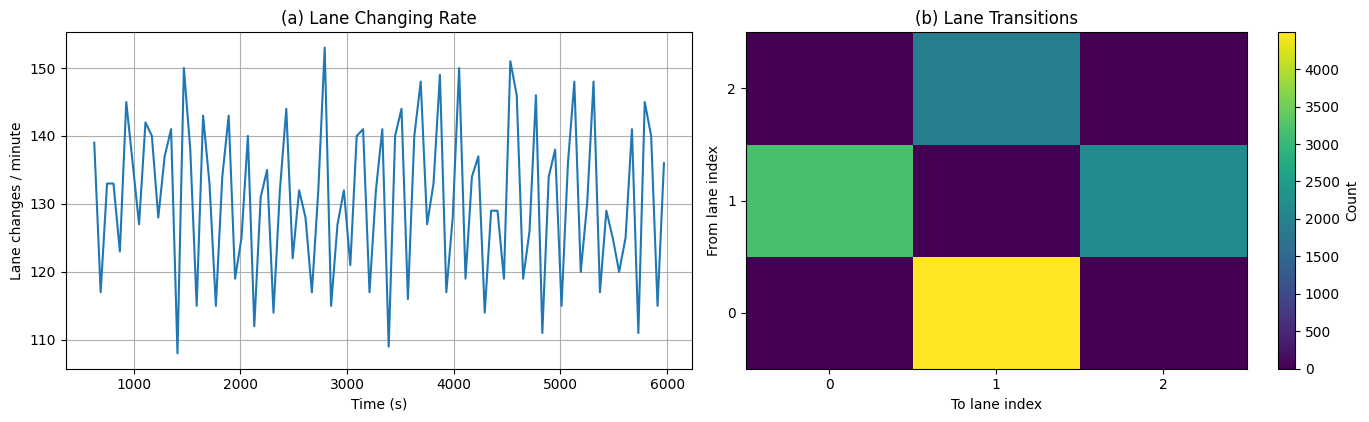

Transition matrix (from -> to) lanes 0/1/2:
[[   0 4491    0]
 [3184    0 2176]
 [   0 1925    0]]


In [57]:
import os
import re
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from collections import defaultdict

# =========================================================
# SETTINGS (EDIT THESE)
# =========================================================
FCD_PATH = "Medium/Output-Default-Priority/fcd.xml"  # <-- set your fcd.xml
WARMUP_SEC = 600.0

BIN_SEC = 60.0          # lane changes per minute
MAX_TIME_SEC = None     # e.g., 5000; None = all
LANES_ALLOWED = {0, 1, 2}

# Your mainline edges (from route edges=...)
MAIN_EDGES_STR = """53187125 99457879 99457861 99457865 1447866124 99457871 1040199894
99457868 99457881 99457867 1040187307 1040187306 54582833 54582832 998964264
1040190012 54641968 54618319 726591114 726591113 726591150 726591149 103504797
103504792 103504816 103504815 50487000 518352630"""
MAIN_EDGES = set(MAIN_EDGES_STR.split())

# =========================================================


def must_exist(path: str):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")


def parse_lane_id(lane_id: str):
    """
    Expected SUMO lane id pattern: "<edgeId>_<laneIndex>"
    Returns (edge_id, lane_idx) or (None, None) if not parseable.
    """
    if lane_id is None:
        return None, None
    if "_" not in lane_id:
        return None, None
    edge, idx = lane_id.rsplit("_", 1)
    try:
        return edge, int(idx)
    except ValueError:
        return None, None


def iter_fcd(fcd_path: str):
    """
    Stream-parse SUMO FCD file.
    Yields (time, list_of_(veh_id, lane_id)).
    """
    context = ET.iterparse(fcd_path, events=("start", "end"))
    _, root = next(context)

    cur_t = None
    vehs = []

    for event, elem in context:
        if event == "start" and elem.tag == "timestep":
            t = elem.get("time")
            cur_t = float(t) if t is not None else None
            vehs = []

        elif event == "end" and elem.tag == "vehicle":
            vid = elem.get("id")
            lane = elem.get("lane")
            if cur_t is not None and vid is not None and lane is not None:
                vehs.append((vid, lane))
            elem.clear()

        elif event == "end" and elem.tag == "timestep":
            if cur_t is not None:
                yield cur_t, vehs
            elem.clear()
            root.clear()


def main():
    must_exist(FCD_PATH)

    # Track last lane index per vehicle (ONLY when it is on main edges and lanes 0/1/2)
    last_lane_idx = {}

    # Time bin counts
    bin_counts = defaultdict(int)

    # Transition matrix counts (3x3 for lanes 0/1/2)
    trans = np.zeros((3, 3), dtype=int)

    for t, vehs in iter_fcd(FCD_PATH):
        if t < WARMUP_SEC:
            continue
        if MAX_TIME_SEC is not None and t > MAX_TIME_SEC:
            break

        for vid, lane_id in vehs:
            edge_id, li = parse_lane_id(lane_id)
            if edge_id is None or li is None:
                continue

            # Restrict to your edges and lane indices 0/1/2
            if edge_id not in MAIN_EDGES:
                continue
            if li not in LANES_ALLOWED:
                continue

            prev = last_lane_idx.get(vid)
            last_lane_idx[vid] = li

            if prev is None:
                continue

            if li != prev:
                # update transition counts (from prev -> li)
                trans[prev, li] += 1

                # update per-minute bin
                b = int((t - WARMUP_SEC) // BIN_SEC)
                bin_counts[b] += 1

    if len(bin_counts) == 0 and trans.sum() == 0:
        raise RuntimeError(
            "No lane changes detected on the specified edges/lanes.\n"
            "Check: FCD has lane=..., vehicles actually use these edges, and lanes are 0/1/2."
        )

    # Build time series arrays
    bins_sorted = sorted(bin_counts.keys())
    times_mid = np.array([(b + 0.5) * BIN_SEC + WARMUP_SEC for b in bins_sorted], dtype=float)
    lc_per_min = np.array([bin_counts[b] for b in bins_sorted], dtype=float) * (60.0 / BIN_SEC)

    # =========================================================
    # PLOT: time series + heatmap
    # =========================================================
    fig, axes = plt.subplots(1, 2, figsize=(14, 4.5))

    # (Left) lane-changes per minute
    axes[0].plot(times_mid, lc_per_min)
    axes[0].set_title("(a) Lane Changing Rate")
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Lane changes / minute")
    axes[0].grid(True)

    # (Right) transition heatmap
    im = axes[1].imshow(trans, origin="lower", aspect="auto", interpolation="nearest")
    axes[1].set_title("(b) Lane Transitions")
    axes[1].set_xlabel("To lane index")
    axes[1].set_ylabel("From lane index")
    axes[1].set_xticks([0, 1, 2])
    axes[1].set_yticks([0, 1, 2])

    cbar = fig.colorbar(im, ax=axes[1])
    cbar.set_label("Count")

    # Bottom subtitle
    # fig.text(
    #     0.5, 0.01,
    #     f"Lane-change frequency and lane-to-lane transition counts on specified mainline edges (lanes 0–2). "
    #     f"Warm-up removed: first {int(WARMUP_SEC)} s.",
    #     ha="center", va="bottom", fontsize=10
    # )

    plt.tight_layout(rect=[0, 0.04, 1, 1])
    plt.show()

    print("Transition matrix (from -> to) lanes 0/1/2:")
    print(trans)


if __name__ == "__main__":
    main()


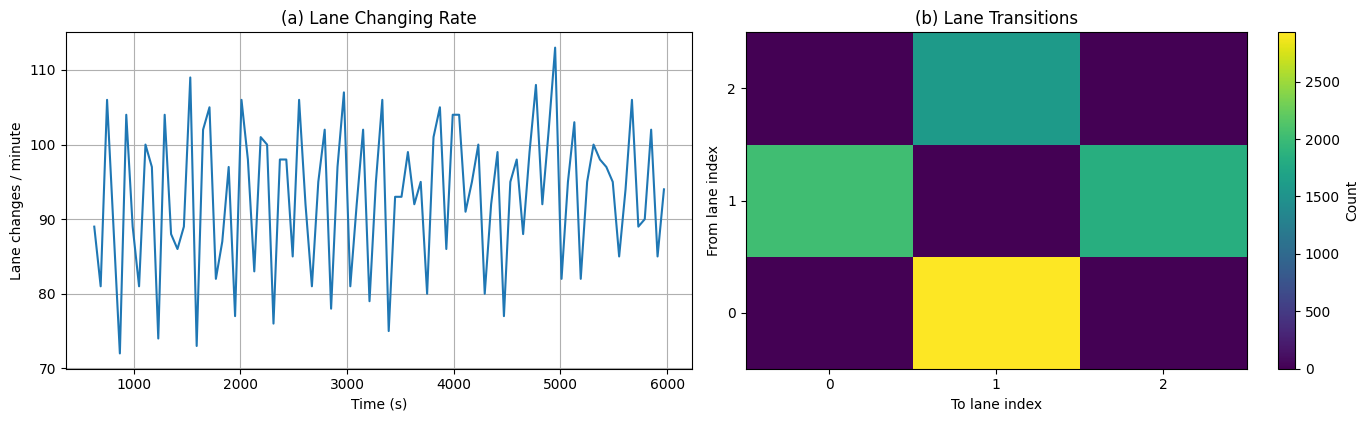

Transition matrix (from -> to) lanes 0/1/2:
[[   0 2929    0]
 [2035    0 1832]
 [   0 1591    0]]


In [58]:
import os
import re
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from collections import defaultdict

# =========================================================
# SETTINGS (EDIT THESE)
# =========================================================
FCD_PATH = "Light/Output-Default-Priority/fcd.xml"  # <-- set your fcd.xml
WARMUP_SEC = 600.0

BIN_SEC = 60.0          # lane changes per minute
MAX_TIME_SEC = None     # e.g., 5000; None = all
LANES_ALLOWED = {0, 1, 2}

# Your mainline edges (from route edges=...)
MAIN_EDGES_STR = """53187125 99457879 99457861 99457865 1447866124 99457871 1040199894
99457868 99457881 99457867 1040187307 1040187306 54582833 54582832 998964264
1040190012 54641968 54618319 726591114 726591113 726591150 726591149 103504797
103504792 103504816 103504815 50487000 518352630"""
MAIN_EDGES = set(MAIN_EDGES_STR.split())

# =========================================================


def must_exist(path: str):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")


def parse_lane_id(lane_id: str):
    """
    Expected SUMO lane id pattern: "<edgeId>_<laneIndex>"
    Returns (edge_id, lane_idx) or (None, None) if not parseable.
    """
    if lane_id is None:
        return None, None
    if "_" not in lane_id:
        return None, None
    edge, idx = lane_id.rsplit("_", 1)
    try:
        return edge, int(idx)
    except ValueError:
        return None, None


def iter_fcd(fcd_path: str):
    """
    Stream-parse SUMO FCD file.
    Yields (time, list_of_(veh_id, lane_id)).
    """
    context = ET.iterparse(fcd_path, events=("start", "end"))
    _, root = next(context)

    cur_t = None
    vehs = []

    for event, elem in context:
        if event == "start" and elem.tag == "timestep":
            t = elem.get("time")
            cur_t = float(t) if t is not None else None
            vehs = []

        elif event == "end" and elem.tag == "vehicle":
            vid = elem.get("id")
            lane = elem.get("lane")
            if cur_t is not None and vid is not None and lane is not None:
                vehs.append((vid, lane))
            elem.clear()

        elif event == "end" and elem.tag == "timestep":
            if cur_t is not None:
                yield cur_t, vehs
            elem.clear()
            root.clear()


def main():
    must_exist(FCD_PATH)

    # Track last lane index per vehicle (ONLY when it is on main edges and lanes 0/1/2)
    last_lane_idx = {}

    # Time bin counts
    bin_counts = defaultdict(int)

    # Transition matrix counts (3x3 for lanes 0/1/2)
    trans = np.zeros((3, 3), dtype=int)

    for t, vehs in iter_fcd(FCD_PATH):
        if t < WARMUP_SEC:
            continue
        if MAX_TIME_SEC is not None and t > MAX_TIME_SEC:
            break

        for vid, lane_id in vehs:
            edge_id, li = parse_lane_id(lane_id)
            if edge_id is None or li is None:
                continue

            # Restrict to your edges and lane indices 0/1/2
            if edge_id not in MAIN_EDGES:
                continue
            if li not in LANES_ALLOWED:
                continue

            prev = last_lane_idx.get(vid)
            last_lane_idx[vid] = li

            if prev is None:
                continue

            if li != prev:
                # update transition counts (from prev -> li)
                trans[prev, li] += 1

                # update per-minute bin
                b = int((t - WARMUP_SEC) // BIN_SEC)
                bin_counts[b] += 1

    if len(bin_counts) == 0 and trans.sum() == 0:
        raise RuntimeError(
            "No lane changes detected on the specified edges/lanes.\n"
            "Check: FCD has lane=..., vehicles actually use these edges, and lanes are 0/1/2."
        )

    # Build time series arrays
    bins_sorted = sorted(bin_counts.keys())
    times_mid = np.array([(b + 0.5) * BIN_SEC + WARMUP_SEC for b in bins_sorted], dtype=float)
    lc_per_min = np.array([bin_counts[b] for b in bins_sorted], dtype=float) * (60.0 / BIN_SEC)

    # =========================================================
    # PLOT: time series + heatmap
    # =========================================================
    fig, axes = plt.subplots(1, 2, figsize=(14, 4.5))

    # (Left) lane-changes per minute
    axes[0].plot(times_mid, lc_per_min)
    axes[0].set_title("(a) Lane Changing Rate")
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Lane changes / minute")
    axes[0].grid(True)

    # (Right) transition heatmap
    im = axes[1].imshow(trans, origin="lower", aspect="auto", interpolation="nearest")
    axes[1].set_title("(b) Lane Transitions")
    axes[1].set_xlabel("To lane index")
    axes[1].set_ylabel("From lane index")
    axes[1].set_xticks([0, 1, 2])
    axes[1].set_yticks([0, 1, 2])

    cbar = fig.colorbar(im, ax=axes[1])
    cbar.set_label("Count")

    # Bottom subtitle
    # fig.text(
    #     0.5, 0.01,
    #     f"Lane-change frequency and lane-to-lane transition counts on specified mainline edges (lanes 0–2). "
    #     f"Warm-up removed: first {int(WARMUP_SEC)} s.",
    #     ha="center", va="bottom", fontsize=10
    # )

    plt.tight_layout(rect=[0, 0.04, 1, 1])
    plt.show()

    print("Transition matrix (from -> to) lanes 0/1/2:")
    print(trans)


if __name__ == "__main__":
    main()


[Light] total lane-changes counted = 8387
[Medium] total lane-changes counted = 11776
[Heavy] total lane-changes counted = 13160


C:\Users\tasni\AppData\Local\Temp\ipykernel_5404\65439647.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.04, 1, 1])


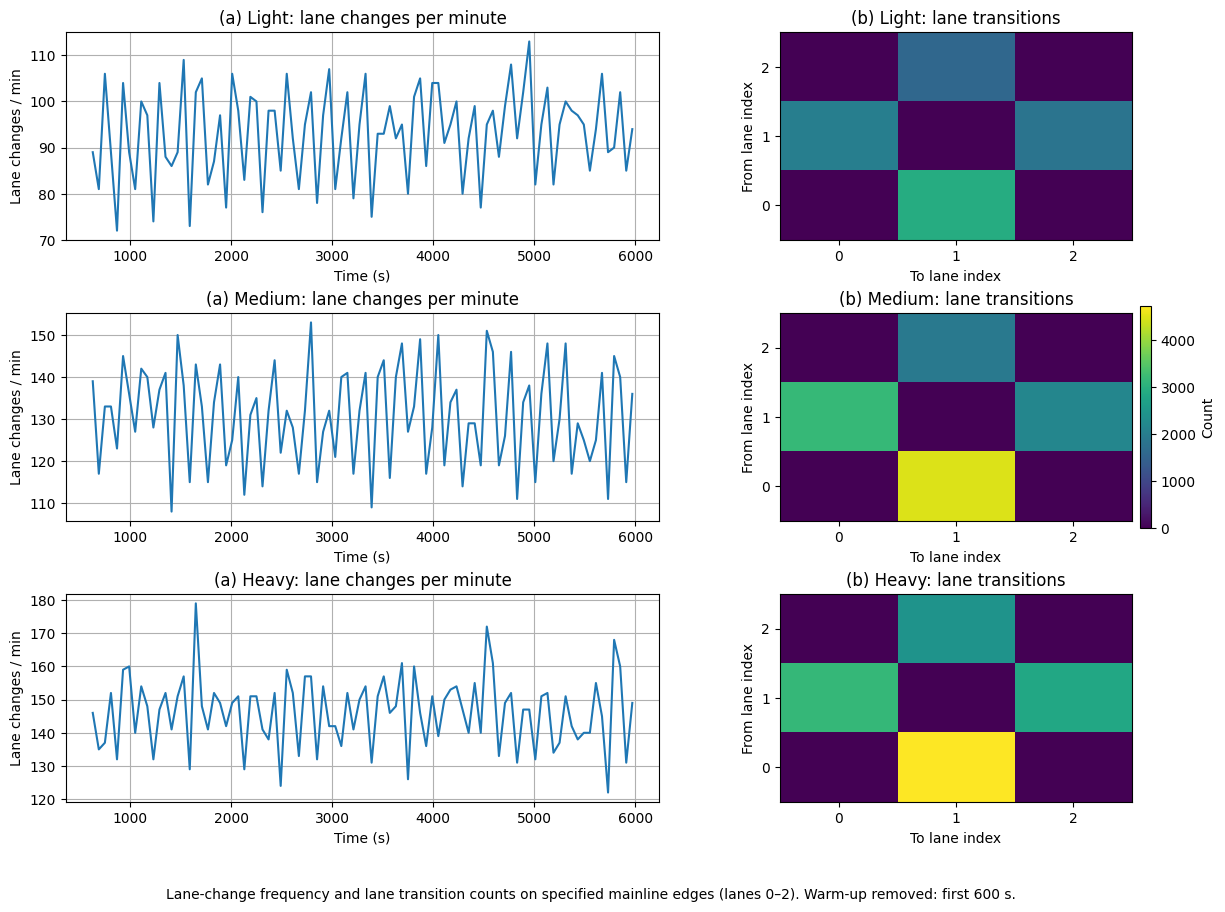

In [54]:
import os
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from collections import defaultdict

# =========================================================
# SETTINGS (EDIT THESE)
# =========================================================
SCENARIOS = {
    "Light":  "Light/Output-Default-Priority/fcd.xml",
    "Medium": "Medium/Output-Default-Priority/fcd.xml",
    "Heavy":  "Heavy/Output-Default-Priority/fcd.xml",
}

WARMUP_SEC = 600.0
BIN_SEC = 60.0          # lane changes per minute
MAX_TIME_SEC = None     # e.g., 5000; None = all
LANES_ALLOWED = {0, 1, 2}

# Your mainline edges (from route edges=...)
MAIN_EDGES_STR = """53187125 99457879 99457861 99457865 1447866124 99457871 1040199894
99457868 99457881 99457867 1040187307 1040187306 54582833 54582832 998964264
1040190012 54641968 54618319 726591114 726591113 726591150 726591149 103504797
103504792 103504816 103504815 50487000 518352630"""
MAIN_EDGES = set(MAIN_EDGES_STR.split())

OUT_PATH = "lanechange_3demands_rows.png"
SAVE = False  # set True to save OUT_PATH
# =========================================================


def must_exist(path: str):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")


def parse_lane_id(lane_id: str):
    """Expected lane id: '<edgeId>_<laneIndex>' -> (edgeId, laneIndex)"""
    if lane_id is None or "_" not in lane_id:
        return None, None
    edge, idx = lane_id.rsplit("_", 1)
    try:
        return edge, int(idx)
    except ValueError:
        return None, None


def iter_fcd(fcd_path: str):
    """Stream parse SUMO FCD: yields (time, [(veh_id, lane_id), ...])"""
    context = ET.iterparse(fcd_path, events=("start", "end"))
    _, root = next(context)

    cur_t = None
    vehs = []

    for event, elem in context:
        if event == "start" and elem.tag == "timestep":
            t = elem.get("time")
            cur_t = float(t) if t is not None else None
            vehs = []

        elif event == "end" and elem.tag == "vehicle":
            vid = elem.get("id")
            lane = elem.get("lane")
            if cur_t is not None and vid is not None and lane is not None:
                vehs.append((vid, lane))
            elem.clear()

        elif event == "end" and elem.tag == "timestep":
            if cur_t is not None:
                yield cur_t, vehs
            elem.clear()
            root.clear()


def compute_lanechange_metrics(fcd_path: str):
    """
    Returns:
      times_mid (array), lc_per_min (array), trans (3x3 int array)
    """
    must_exist(fcd_path)

    last_lane_idx = {}                 # vehicle -> last lane index (0/1/2)
    bin_counts = defaultdict(int)      # bin -> count
    trans = np.zeros((3, 3), dtype=int)

    for t, vehs in iter_fcd(fcd_path):
        if t < WARMUP_SEC:
            continue
        if MAX_TIME_SEC is not None and t > MAX_TIME_SEC:
            break

        for vid, lane_id in vehs:
            edge_id, li = parse_lane_id(lane_id)
            if edge_id is None or li is None:
                continue
            if edge_id not in MAIN_EDGES:
                continue
            if li not in LANES_ALLOWED:
                continue

            prev = last_lane_idx.get(vid)
            last_lane_idx[vid] = li

            if prev is None:
                continue

            if li != prev:
                trans[prev, li] += 1
                b = int((t - WARMUP_SEC) // BIN_SEC)
                bin_counts[b] += 1

    bins_sorted = sorted(bin_counts.keys())
    times_mid = np.array([(b + 0.5) * BIN_SEC + WARMUP_SEC for b in bins_sorted], dtype=float)
    lc_per_min = np.array([bin_counts[b] for b in bins_sorted], dtype=float) * (60.0 / BIN_SEC)

    return times_mid, lc_per_min, trans


def main():
    order = ["Light", "Medium", "Heavy"]

    # compute all results first (also lets us share axes nicely)
    results = {}
    for name in order:
        fcd = SCENARIOS[name]
        t, lc, trans = compute_lanechange_metrics(fcd)
        results[name] = {"t": t, "lc": lc, "trans": trans}
        print(f"[{name}] total lane-changes counted = {int(trans.sum())}")

    # shared color scale across heatmaps
    vmax = max(int(results[n]["trans"].max()) for n in order)

    # 3 rows x 2 columns:
    # left = lane changes / minute time series
    # right = 3x3 transition heatmap
    fig, axes = plt.subplots(
        nrows=3, ncols=2, figsize=(14, 10),
        gridspec_kw={"width_ratios": [1.6, 1.0], "hspace": 0.35, "wspace": 0.25}
    )

    ims = []
    for i, name in enumerate(order):
        ax_ts = axes[i, 0]
        ax_hm = axes[i, 1]

        t = results[name]["t"]
        lc = results[name]["lc"]
        trans = results[name]["trans"]

        # ---- time series ----
        ax_ts.plot(t, lc)
        ax_ts.set_title(f"(a) {name}: lane changes per minute")
        ax_ts.set_xlabel("Time (s)")
        ax_ts.set_ylabel("Lane changes / min")
        ax_ts.grid(True)

        # ---- heatmap ----
        im = ax_hm.imshow(
            trans, origin="lower", aspect="auto", interpolation="nearest",
            vmin=0, vmax=vmax
        )
        ims.append(im)
        ax_hm.set_title(f"(b) {name}: lane transitions")
        ax_hm.set_xlabel("To lane index")
        ax_hm.set_ylabel("From lane index")
        ax_hm.set_xticks([0, 1, 2])
        ax_hm.set_yticks([0, 1, 2])

    # one shared colorbar for all heatmaps
    cbar = fig.colorbar(ims[-1], ax=axes[:, 1], fraction=0.03, pad=0.02)
    cbar.set_label("Count")

    # bottom subtitle
    fig.text(
        0.5, 0.01,
        f"Lane-change frequency and lane transition counts on specified mainline edges (lanes 0–2). "
        f"Warm-up removed: first {int(WARMUP_SEC)} s.",
        ha="center", va="bottom", fontsize=10
    )

    plt.tight_layout(rect=[0, 0.04, 1, 1])
    if SAVE:
        plt.savefig(OUT_PATH, dpi=200)
        print(f"Saved: {OUT_PATH}")
    plt.show()


if __name__ == "__main__":
    main()


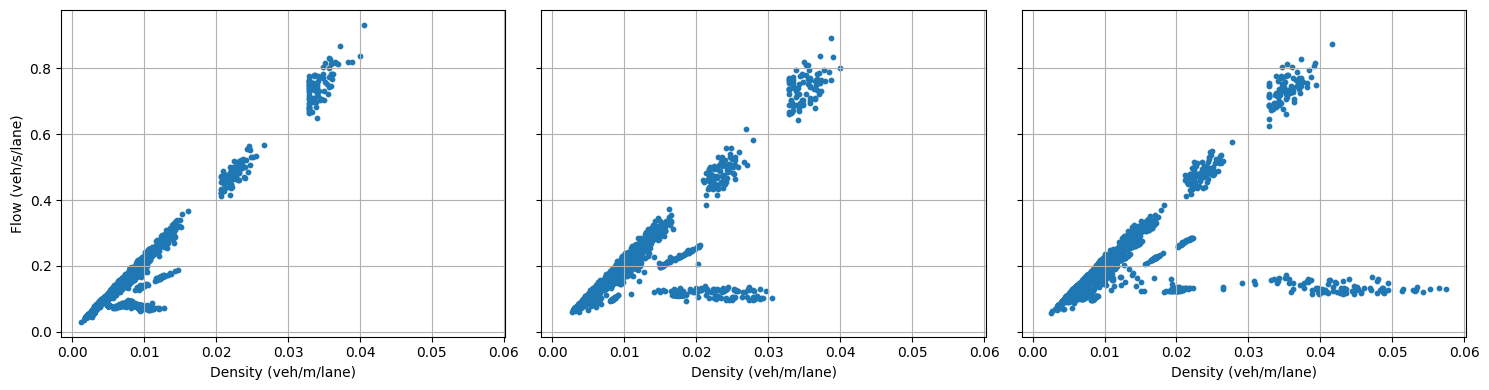

Saved: FD_mainline_fcd_all_scenarios_per_meter.csv


In [10]:
"""
Flow–Density fundamental diagram (FCD-based) for MAINLINE edges,
plotted side-by-side for Light / Medium / Heavy in subplots.

PER-METER UNITS:
- density: veh/m/lane
- flow:    veh/s/lane
- speed:   m/s

Assumptions:
- Net file is in the PROJECT ROOT (single net for all scenarios).
- Each scenario folder contains fcd.xml (or edit FCD_NAME).
"""

from pathlib import Path
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# USER SETTINGS
# -----------------------------
SCENARIOS = {
    "Light":  r"Light/Output-Default-Priority",
    "Medium": r"Medium/Output-Default-Priority",
    "Heavy":  r"Heavy/Output-Default-Priority",
}

FCD_NAME = "fcd.xml"  # change if your file name differs

# ✅ NET FILE IS IN ROOT (NOT inside scenario folders)
NET_XML = Path("Default-priority-network.net.xml")

WARMUP_SEC = 600.0
END_SEC = None      # e.g., 6000.0
AGG_SEC = 60.0      # time bin size for FD points

MAINLINE_EDGES = [
    "53187125","99457879","99457861","99457865","1447866124","99457871","1040199894",
    "99457868","99457881","99457867","1040187307","1040187306","54582833","54582832",
    "998964264","1040190012","54641968","54618319","726591114","726591113","726591150",
    "726591149","103504797","103504792","103504816","103504815","50487000","518352630"
]

# -----------------------------
# Helpers
# -----------------------------
def read_net_edge_info(net_xml: Path):
    if not net_xml.exists():
        raise FileNotFoundError(f"NET XML not found: {net_xml.resolve()}")

    tree = ET.parse(net_xml)
    root = tree.getroot()

    edge_len = {}
    edge_lanes = {}

    for e in root.findall("edge"):
        eid = e.get("id")
        if eid is None or eid.startswith(":"):
            continue
        lanes = e.findall("lane")
        if not lanes:
            continue
        length = float(lanes[0].get("length"))  # meters
        nlanes = len(lanes)

        edge_len[eid] = length
        edge_lanes[eid] = nlanes

    return edge_len, edge_lanes


def fcd_edge_time_stats(fcd_xml: Path, edge_len: dict, edge_lanes: dict,
                        warmup_sec: float, end_sec: float | None,
                        corridor_edges: set[str]) -> pd.DataFrame:
    """
    Per timestep & per edge (PER-METER):
      density = N / (L_m * nLanes)      [veh/m/lane]
      v_ms    space-mean speed          [m/s]
      flow    = density * v_ms          [veh/s/lane]
    """
    rows = []
    context = ET.iterparse(fcd_xml, events=("start", "end"))
    _, root = next(context)

    current_time = None
    counts = {}
    speed_sums = {}

    for event, elem in context:
        if event == "start" and elem.tag == "timestep":
            current_time = float(elem.get("time"))
            counts = {}
            speed_sums = {}

        elif event == "end" and elem.tag == "vehicle":
            if current_time is None:
                continue
            if current_time < warmup_sec:
                continue
            if end_sec is not None and current_time > end_sec:
                continue

            lane_id = elem.get("lane")
            if lane_id is None:
                continue

            # lane id commonly looks like "edgeID_0" -> edgeID
            edge_id = lane_id.rsplit("_", 1)[0]

            if edge_id not in corridor_edges:
                continue
            if edge_id not in edge_len or edge_id not in edge_lanes:
                continue

            v_ms = float(elem.get("speed", "0.0"))
            counts[edge_id] = counts.get(edge_id, 0) + 1
            speed_sums[edge_id] = speed_sums.get(edge_id, 0.0) + v_ms

        elif event == "end" and elem.tag == "timestep":
            if current_time is not None and current_time >= warmup_sec and (end_sec is None or current_time <= end_sec):
                for edge_id, n in counts.items():
                    L_m = edge_len[edge_id]
                    nlanes = edge_lanes[edge_id]
                    if L_m <= 0 or nlanes <= 0:
                        continue

                    v_mean_ms = speed_sums[edge_id] / max(n, 1)

                    # ✅ per-meter density (veh/m/lane)
                    density = n / (L_m * nlanes)

                    # ✅ per-meter flow (veh/s/lane)
                    flow = density * v_mean_ms

                    rows.append((current_time, edge_id, density, flow, v_mean_ms, n))

            elem.clear()
            root.clear()

    return pd.DataFrame(rows, columns=["time", "edge", "density", "flow", "v_ms", "nVeh"])


def aggregate_fd(df: pd.DataFrame, agg_sec: float) -> pd.DataFrame:
    if df.empty:
        return df

    out = df.copy()
    out["bin"] = (out["time"] // agg_sec).astype(int)

    agg = (
        out.groupby(["edge", "bin"], as_index=False)
           .agg(
               time_start=("time", "min"),
               time_end=("time", "max"),
               density=("density", "mean"),  # veh/m/lane
               flow=("flow", "mean"),        # veh/s/lane
               v_ms=("v_ms", "mean"),
               nVeh=("nVeh", "mean"),
           )
    )
    return agg


def load_scenario_fd(folder: str, edge_len: dict, edge_lanes: dict,
                     warmup: float, end_sec: float | None,
                     agg_sec: float, corridor_edges: list[str]) -> pd.DataFrame:
    folder = Path(folder)
    fcd = folder / FCD_NAME
    if not fcd.exists():
        raise FileNotFoundError(f"FCD not found: {fcd.resolve()}")

    df_raw = fcd_edge_time_stats(
        fcd,
        edge_len=edge_len,
        edge_lanes=edge_lanes,
        warmup_sec=warmup,
        end_sec=end_sec,
        corridor_edges=set(corridor_edges),
    )
    return aggregate_fd(df_raw, agg_sec)


# -----------------------------
# MAIN
# -----------------------------
edge_len, edge_lanes = read_net_edge_info(NET_XML)

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)
labels = list(SCENARIOS.keys())

all_fd = []

for ax, name in zip(axes, labels):
    folder = SCENARIOS[name]
    df_fd = load_scenario_fd(folder, edge_len, edge_lanes, WARMUP_SEC, END_SEC, AGG_SEC, MAINLINE_EDGES)
    df_fd["scenario"] = name
    all_fd.append(df_fd)

    if df_fd.empty:
        ax.set_title(f"{name} (no data)")
        ax.grid(True)
        continue

    ax.scatter(df_fd["density"], df_fd["flow"], s=10)
    # ax.set_title(name)
    ax.set_xlabel("Density (veh/m/lane)")
    ax.grid(True)

axes[0].set_ylabel("Flow (veh/s/lane)")
plt.tight_layout()
plt.show()

df_all = pd.concat(all_fd, ignore_index=True) if all_fd else pd.DataFrame()
df_all.to_csv("FD_mainline_fcd_all_scenarios_per_meter.csv", index=False)
print("Saved: FD_mainline_fcd_all_scenarios_per_meter.csv")


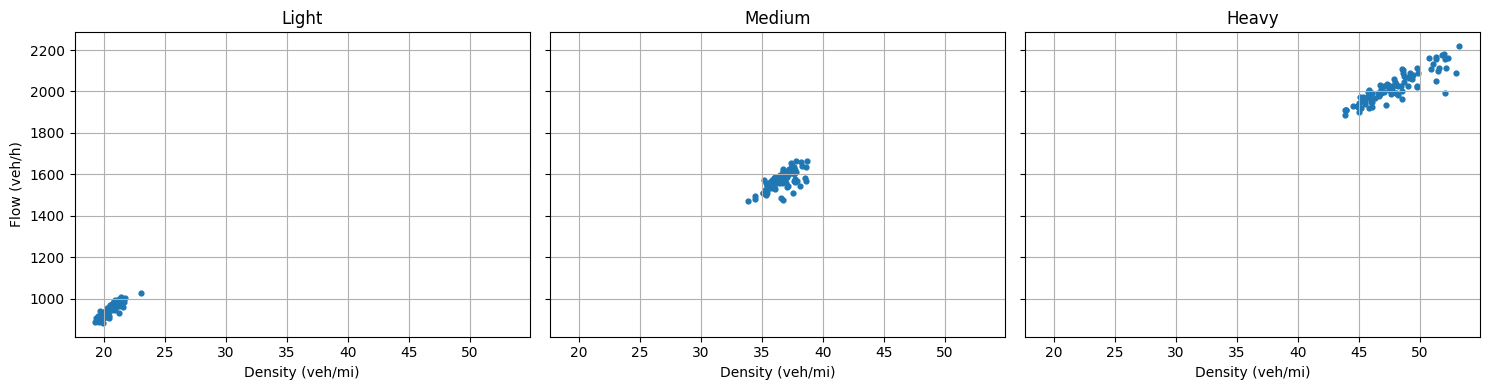

Saved: FD_mainline_CORRIDOR_veh_per_mile.csv


In [3]:
"""
Fundamental Diagram from FCD for COMPLETE MAINLINE (corridor-aggregated),
side-by-side for Light / Medium / Heavy.

UNITS:
- density: veh/mi  (NOT per lane)
- flow:    veh/h   (NOT per lane)
- speed:   mi/h

Method:
At each timestep:
  N_mainline(t) = sum vehicles on all mainline edges
  k(t) = N_mainline(t) / L_mainline_mi
  v(t) = length-weighted mean speed over edges (mi/h)
  q(t) = k(t) * v(t)

Then aggregate into AGG_SEC bins and plot q vs k.
"""

from pathlib import Path
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# USER SETTINGS
# -----------------------------
SCENARIOS = {
    "Light":  r"Light/Output-Default-Priority",
    "Medium": r"Medium/Output-Default-Priority",
    "Heavy":  r"Heavy/Output-Default-Priority",
}

FCD_NAME = "fcd.xml"
NET_XML = Path("Default-priority-network.net.xml")

WARMUP_SEC = 600.0
END_SEC = None
AGG_SEC = 60.0

MAINLINE_EDGES = [
    "53187125","99457879","99457861","99457865","1447866124","99457871","1040199894",
    "99457868","99457881","99457867","1040187307","1040187306","54582833","54582832",
    "998964264","1040190012","54641968","54618319","726591114","726591113","726591150",
    "726591149","103504797","103504792","103504816","103504815","50487000","518352630"
]

M_PER_MILE = 1609.344

# -----------------------------
# Network parsing (edge length in meters)
# -----------------------------
def read_net_edge_lengths(net_xml: Path):
    if not net_xml.exists():
        raise FileNotFoundError(f"NET XML not found: {net_xml.resolve()}")

    tree = ET.parse(net_xml)
    root = tree.getroot()

    edge_len_m = {}
    for e in root.findall("edge"):
        eid = e.get("id")
        if eid is None or eid.startswith(":"):
            continue
        lanes = e.findall("lane")
        if not lanes:
            continue
        edge_len_m[eid] = float(lanes[0].get("length"))
    return edge_len_m


# -----------------------------
# Stream FCD and compute corridor aggregates at each timestep
# -----------------------------
def mainline_time_series_from_fcd(
    fcd_xml: Path,
    edge_len_m: dict,
    mainline_edges: list[str],
    warmup_sec: float,
    end_sec: float | None
) -> pd.DataFrame:
    """
    Returns per-timestep corridor series:
      time, N_mainline, density_veh_per_mi, speed_mph, flow_vph
    """
    mainline_set = set(mainline_edges)

    # total corridor length (mi), constant
    L_mainline_m = sum(edge_len_m[e] for e in mainline_edges if e in edge_len_m)
    if L_mainline_m <= 0:
        raise ValueError("Mainline length computed as 0. Check edge IDs match net.xml.")
    L_mainline_mi = L_mainline_m / M_PER_MILE

    rows = []
    context = ET.iterparse(fcd_xml, events=("start", "end"))
    _, root = next(context)

    current_time = None

    # per timestep accumulators
    counts = {}       # edge -> N
    speed_sums = {}   # edge -> sum(v_ms)
    # (we’ll compute mean speed per edge = speed_sums/ counts)

    for event, elem in context:
        if event == "start" and elem.tag == "timestep":
            current_time = float(elem.get("time"))
            counts = {}
            speed_sums = {}

        elif event == "end" and elem.tag == "vehicle":
            if current_time is None:
                continue
            if current_time < warmup_sec:
                continue
            if end_sec is not None and current_time > end_sec:
                continue

            lane_id = elem.get("lane")
            if lane_id is None:
                continue
            edge_id = lane_id.rsplit("_", 1)[0]

            if edge_id not in mainline_set:
                continue
            if edge_id not in edge_len_m:
                continue

            v_ms = float(elem.get("speed", "0.0"))
            counts[edge_id] = counts.get(edge_id, 0) + 1
            speed_sums[edge_id] = speed_sums.get(edge_id, 0.0) + v_ms

        elif event == "end" and elem.tag == "timestep":
            if current_time is not None and current_time >= warmup_sec and (end_sec is None or current_time <= end_sec):

                # N_mainline(t)
                N_mainline = sum(counts.values())

                # density veh/mi (NOT per lane)
                density = N_mainline / L_mainline_mi  # veh/mi

                # length-weighted speed across edges (mph)
                # compute mean speed per edge, then weight by edge length
                num = 0.0
                den = 0.0
                for e, n in counts.items():
                    if n <= 0:
                        continue
                    Lm = edge_len_m.get(e, 0.0)
                    if Lm <= 0:
                        continue
                    v_edge_ms = speed_sums[e] / n
                    num += v_edge_ms * Lm
                    den += Lm

                v_mainline_ms = (num / den) if den > 0 else 0.0
                v_mainline_mph = v_mainline_ms * 2.2369362920544

                # flow veh/h (NOT per lane)
                flow = density * v_mainline_mph  # veh/h

                rows.append((current_time, N_mainline, density, v_mainline_mph, flow))

            elem.clear()
            root.clear()

    return pd.DataFrame(rows, columns=["time", "N_mainline", "density_veh_per_mi", "speed_mph", "flow_vph"])


def aggregate_bins(df: pd.DataFrame, agg_sec: float) -> pd.DataFrame:
    if df.empty:
        return df
    out = df.copy()
    out["bin"] = (out["time"] // agg_sec).astype(int)

    # average density and flow within each bin (typical FD practice)
    agg = (
        out.groupby("bin", as_index=False)
           .agg(
               time_start=("time", "min"),
               time_end=("time", "max"),
               density_veh_per_mi=("density_veh_per_mi", "mean"),
               flow_vph=("flow_vph", "mean"),
               speed_mph=("speed_mph", "mean"),
               N_mainline=("N_mainline", "mean"),
           )
    )
    return agg


# -----------------------------
# MAIN
# -----------------------------
edge_len_m = read_net_edge_lengths(NET_XML)

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

all_out = []
for ax, (name, folder) in zip(axes, SCENARIOS.items()):
    fcd_path = Path(folder) / FCD_NAME
    if not fcd_path.exists():
        raise FileNotFoundError(f"FCD not found: {fcd_path.resolve()}")

    ts = mainline_time_series_from_fcd(
        fcd_path, edge_len_m, MAINLINE_EDGES, WARMUP_SEC, END_SEC
    )
    fd = aggregate_bins(ts, AGG_SEC)
    fd["scenario"] = name
    all_out.append(fd)

    if fd.empty:
        ax.set_title(f"{name} (no data)")
        ax.grid(True)
        continue

    ax.scatter(fd["density_veh_per_mi"], fd["flow_vph"], s=12)
    ax.set_title(name)
    ax.set_xlabel("Density (veh/mi)")
    ax.grid(True)

axes[0].set_ylabel("Flow (veh/h)")
plt.tight_layout()
plt.show()

df_all = pd.concat(all_out, ignore_index=True) if all_out else pd.DataFrame()
df_all.to_csv("FD_mainline_CORRIDOR_veh_per_mile.csv", index=False)
print("Saved: FD_mainline_CORRIDOR_veh_per_mile.csv")


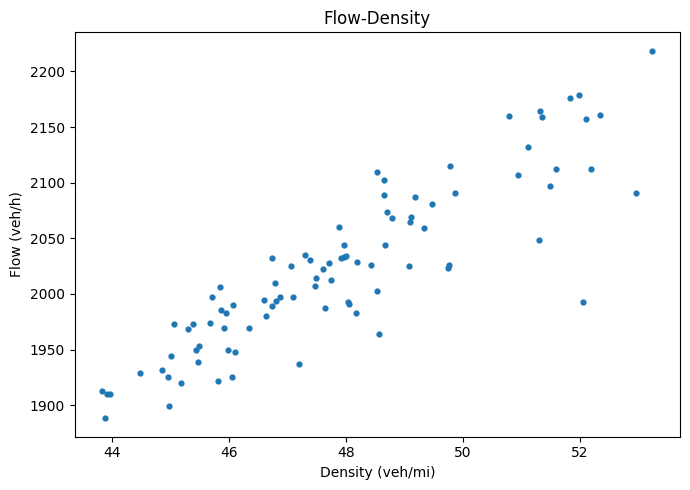

Saved: FD_mainline_CORRIDOR_high_veh_per_mile.csv


In [14]:
"""
Fundamental Diagram from FCD for COMPLETE MAINLINE (corridor-aggregated),
ONLY for HIGH demand.

UNITS:
- density: veh/mi  (NOT per lane)
- flow:    veh/h   (NOT per lane)
- speed:   mi/h

Method:
At each timestep:
  N_mainline(t) = sum vehicles on all mainline edges
  k(t) = N_mainline(t) / L_mainline_mi
  v(t) = length-weighted mean speed over edges (mi/h)
  q(t) = k(t) * v(t)

Then aggregate into AGG_SEC bins and plot q vs k.
"""

from pathlib import Path
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# USER SETTINGS (HIGH ONLY)
# -----------------------------
HIGH_FOLDER = r"Heavy/Output-Default-Priority"   # <-- change if your folder name differs
FCD_NAME = "fcd.xml"
NET_XML = Path("Default-priority-network.net.xml")

WARMUP_SEC = 600.0
END_SEC = None
AGG_SEC = 60.0

MAINLINE_EDGES = [
    "53187125","99457879","99457861","99457865","1447866124","99457871","1040199894",
    "99457868","99457881","99457867","1040187307","1040187306","54582833","54582832",
    "998964264","1040190012","54641968","54618319","726591114","726591113","726591150",
    "726591149","103504797","103504792","103504816","103504815","50487000","518352630"
]

M_PER_MILE = 1609.344
MS_TO_MPH = 2.2369362920544

# -----------------------------
# Network parsing (edge length in meters)
# -----------------------------
def read_net_edge_lengths(net_xml: Path):
    if not net_xml.exists():
        raise FileNotFoundError(f"NET XML not found: {net_xml.resolve()}")

    tree = ET.parse(net_xml)
    root = tree.getroot()

    edge_len_m = {}
    for e in root.findall("edge"):
        eid = e.get("id")
        if eid is None or eid.startswith(":"):
            continue
        lanes = e.findall("lane")
        if not lanes:
            continue
        edge_len_m[eid] = float(lanes[0].get("length"))
    return edge_len_m


# -----------------------------
# Stream FCD and compute corridor aggregates at each timestep
# -----------------------------
def mainline_time_series_from_fcd(
    fcd_xml: Path,
    edge_len_m: dict,
    mainline_edges: list[str],
    warmup_sec: float,
    end_sec: float | None
) -> pd.DataFrame:
    """
    Returns per-timestep corridor series:
      time, N_mainline, density_veh_per_mi, speed_mph, flow_vph
    """
    mainline_set = set(mainline_edges)

    # total corridor length (mi), constant
    L_mainline_m = sum(edge_len_m[e] for e in mainline_edges if e in edge_len_m)
    if L_mainline_m <= 0:
        raise ValueError("Mainline length computed as 0. Check edge IDs match net.xml.")
    L_mainline_mi = L_mainline_m / M_PER_MILE

    rows = []
    context = ET.iterparse(fcd_xml, events=("start", "end"))
    _, root = next(context)

    current_time = None
    counts = {}
    speed_sums = {}

    for event, elem in context:
        if event == "start" and elem.tag == "timestep":
            current_time = float(elem.get("time"))
            counts = {}
            speed_sums = {}

        elif event == "end" and elem.tag == "vehicle":
            if current_time is None:
                continue
            if current_time < warmup_sec:
                continue
            if end_sec is not None and current_time > end_sec:
                continue

            lane_id = elem.get("lane")
            if lane_id is None:
                continue
            edge_id = lane_id.rsplit("_", 1)[0]

            if edge_id not in mainline_set:
                continue
            if edge_id not in edge_len_m:
                continue

            v_ms = float(elem.get("speed", "0.0"))
            counts[edge_id] = counts.get(edge_id, 0) + 1
            speed_sums[edge_id] = speed_sums.get(edge_id, 0.0) + v_ms

        elif event == "end" and elem.tag == "timestep":
            if current_time is not None and current_time >= warmup_sec and (end_sec is None or current_time <= end_sec):
                N_mainline = sum(counts.values())
                density = N_mainline / L_mainline_mi  # veh/mi

                # length-weighted speed across edges (mph)
                num = 0.0
                den = 0.0
                for e, n in counts.items():
                    if n <= 0:
                        continue
                    Lm = edge_len_m.get(e, 0.0)
                    if Lm <= 0:
                        continue
                    v_edge_ms = speed_sums[e] / n
                    num += v_edge_ms * Lm
                    den += Lm

                v_mainline_ms = (num / den) if den > 0 else 0.0
                v_mainline_mph = v_mainline_ms * MS_TO_MPH

                flow = density * v_mainline_mph  # veh/h

                rows.append((current_time, N_mainline, density, v_mainline_mph, flow))

            elem.clear()
            root.clear()

    return pd.DataFrame(rows, columns=["time", "N_mainline", "density_veh_per_mi", "speed_mph", "flow_vph"])


def aggregate_bins(df: pd.DataFrame, agg_sec: float) -> pd.DataFrame:
    if df.empty:
        return df

    out = df.copy()
    out["bin"] = (out["time"] // agg_sec).astype(int)

    agg = (
        out.groupby("bin", as_index=False)
           .agg(
               time_start=("time", "min"),
               time_end=("time", "max"),
               density_veh_per_mi=("density_veh_per_mi", "mean"),
               flow_vph=("flow_vph", "mean"),
               speed_mph=("speed_mph", "mean"),
               N_mainline=("N_mainline", "mean"),
           )
    )
    return agg


# -----------------------------
# MAIN (HIGH ONLY)
# -----------------------------
edge_len_m = read_net_edge_lengths(NET_XML)

fcd_path = Path(HIGH_FOLDER) / FCD_NAME
if not fcd_path.exists():
    raise FileNotFoundError(f"FCD not found: {fcd_path.resolve()}")

ts = mainline_time_series_from_fcd(
    fcd_path, edge_len_m, MAINLINE_EDGES, WARMUP_SEC, END_SEC
)
fd = aggregate_bins(ts, AGG_SEC)

# Plot (single plot)
plt.figure(figsize=(7, 5))
plt.scatter(fd["density_veh_per_mi"], fd["flow_vph"], s=12)
plt.title("Flow-Density")
plt.xlabel("Density (veh/mi)")
plt.ylabel("Flow (veh/h)")
# plt.grid(True)
plt.tight_layout()
plt.show()

fd.to_csv("FD_mainline_CORRIDOR_high_veh_per_mile.csv", index=False)
print("Saved: FD_mainline_CORRIDOR_high_veh_per_mile.csv")


[OK] Saved: FD_mainline_CORRIDOR_Light_veh_per_mile.csv (rows=90)
[OK] Saved: FD_mainline_CORRIDOR_Medium_veh_per_mile.csv (rows=90)
[OK] Saved: FD_mainline_CORRIDOR_Heavy_veh_per_mile.csv (rows=90)


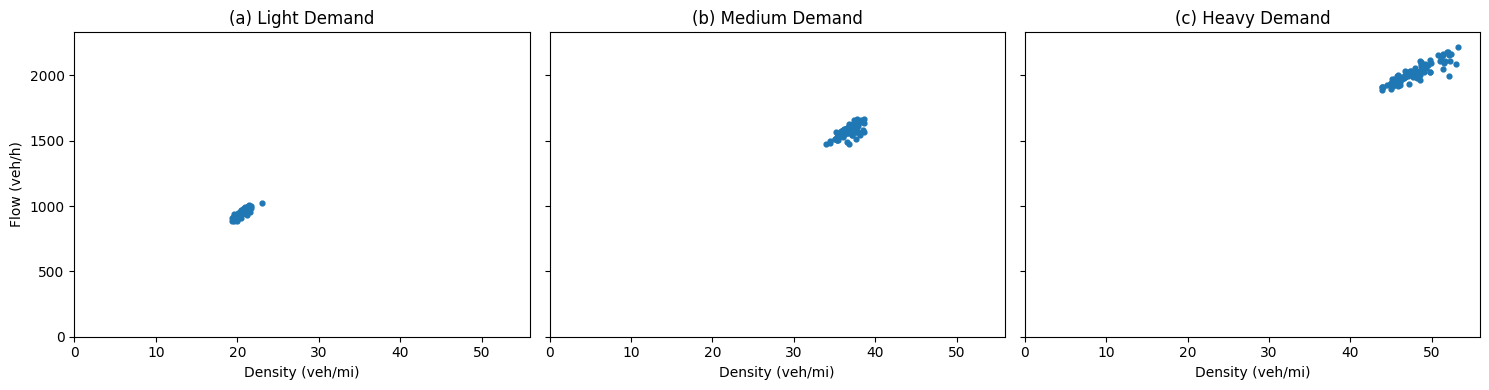

In [24]:
"""
Fundamental Diagram from FCD for COMPLETE MAINLINE (corridor-aggregated),
for THREE demand scenarios (Light/Medium/Heavy), plotted in SUBPLOTS.

UNITS:
- density: veh/mi  (NOT per lane)
- flow:    veh/h   (NOT per lane)
- speed:   mi/h

Method (per timestep):
  N_mainline(t) = sum vehicles on all mainline edges
  k(t) = N_mainline(t) / L_mainline_mi
  v(t) = length-weighted mean speed over edges (mi/h)
  q(t) = k(t) * v(t)

Then aggregate into AGG_SEC bins and plot q vs k.
"""

from pathlib import Path
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# USER SETTINGS
# -----------------------------
NET_XML = Path("Default-priority-network.net.xml")  # <-- your net file
FCD_NAME = "fcd.xml"

SCENARIOS = {
    "Light":  r"Light/Output-Default-Priority",
    "Medium": r"Medium/Output-Default-Priority",
    "Heavy":  r"Heavy/Output-Default-Priority",
}

WARMUP_SEC = 600.0
END_SEC = None
AGG_SEC = 60.0

MAINLINE_EDGES = [
    "53187125","99457879","99457861","99457865","1447866124","99457871","1040199894",
    "99457868","99457881","99457867","1040187307","1040187306","54582833","54582832",
    "998964264","1040190012","54641968","54618319","726591114","726591113","726591150",
    "726591149","103504797","103504792","103504816","103504815","50487000","518352630"
]

M_PER_MILE = 1609.344
MS_TO_MPH = 2.2369362920544

# -----------------------------
# Network parsing (edge length in meters)
# -----------------------------
def read_net_edge_lengths(net_xml: Path) -> dict[str, float]:
    if not net_xml.exists():
        raise FileNotFoundError(f"NET XML not found: {net_xml.resolve()}")

    tree = ET.parse(net_xml)
    root = tree.getroot()

    edge_len_m: dict[str, float] = {}
    for e in root.findall("edge"):
        eid = e.get("id")
        if eid is None or eid.startswith(":"):
            continue
        lanes = e.findall("lane")
        if not lanes:
            continue
        edge_len_m[eid] = float(lanes[0].get("length"))
    return edge_len_m

# -----------------------------
# Stream FCD and compute corridor aggregates at each timestep
# -----------------------------
def mainline_time_series_from_fcd(
    fcd_xml: Path,
    edge_len_m: dict[str, float],
    mainline_edges: list[str],
    warmup_sec: float,
    end_sec: float | None
) -> pd.DataFrame:
    """
    Returns per-timestep corridor series:
      time, N_mainline, density_veh_per_mi, speed_mph, flow_vph
    """
    mainline_set = set(mainline_edges)

    # total corridor length (mi), constant
    L_mainline_m = sum(edge_len_m[e] for e in mainline_edges if e in edge_len_m)
    if L_mainline_m <= 0:
        raise ValueError("Mainline length computed as 0. Check edge IDs match net.xml.")
    L_mainline_mi = L_mainline_m / M_PER_MILE

    rows = []
    context = ET.iterparse(fcd_xml, events=("start", "end"))
    _, root = next(context)

    current_time = None
    counts: dict[str, int] = {}
    speed_sums: dict[str, float] = {}

    for event, elem in context:
        if event == "start" and elem.tag == "timestep":
            current_time = float(elem.get("time"))
            counts = {}
            speed_sums = {}

        elif event == "end" and elem.tag == "vehicle":
            if current_time is None:
                continue
            if current_time < warmup_sec:
                continue
            if end_sec is not None and current_time > end_sec:
                continue

            lane_id = elem.get("lane")
            if lane_id is None:
                continue
            # SUMO lane id is often edgeId_laneIndex -> recover edgeId
            edge_id = lane_id.rsplit("_", 1)[0]

            if edge_id not in mainline_set:
                continue
            if edge_id not in edge_len_m:
                continue

            v_ms = float(elem.get("speed", "0.0"))
            counts[edge_id] = counts.get(edge_id, 0) + 1
            speed_sums[edge_id] = speed_sums.get(edge_id, 0.0) + v_ms

        elif event == "end" and elem.tag == "timestep":
            if current_time is not None and current_time >= warmup_sec and (end_sec is None or current_time <= end_sec):
                N_mainline = sum(counts.values())
                density = N_mainline / L_mainline_mi  # veh/mi

                # length-weighted mean speed across edges (mph)
                num = 0.0
                den = 0.0
                for e, n in counts.items():
                    if n <= 0:
                        continue
                    Lm = edge_len_m.get(e, 0.0)
                    if Lm <= 0:
                        continue
                    v_edge_ms = speed_sums[e] / n
                    num += v_edge_ms * Lm
                    den += Lm

                v_mainline_ms = (num / den) if den > 0 else 0.0
                v_mainline_mph = v_mainline_ms * MS_TO_MPH
                flow = density * v_mainline_mph  # veh/h

                rows.append((current_time, N_mainline, density, v_mainline_mph, flow))

            elem.clear()
            root.clear()

    return pd.DataFrame(
        rows,
        columns=["time", "N_mainline", "density_veh_per_mi", "speed_mph", "flow_vph"]
    )

def aggregate_bins(df: pd.DataFrame, agg_sec: float) -> pd.DataFrame:
    if df.empty:
        return df

    out = df.copy()
    out["bin"] = (out["time"] // agg_sec).astype(int)

    return (
        out.groupby("bin", as_index=False)
           .agg(
               time_start=("time", "min"),
               time_end=("time", "max"),
               density_veh_per_mi=("density_veh_per_mi", "mean"),
               flow_vph=("flow_vph", "mean"),
               speed_mph=("speed_mph", "mean"),
               N_mainline=("N_mainline", "mean"),
           )
    )

# -----------------------------
# MAIN: run scenarios
# -----------------------------
edge_len_m = read_net_edge_lengths(NET_XML)

results: dict[str, pd.DataFrame] = {}

for scen_name, folder in SCENARIOS.items():
    fcd_path = Path(folder) / FCD_NAME
    if not fcd_path.exists():
        print(f"[SKIP] {scen_name}: FCD not found: {fcd_path.resolve()}")
        continue

    ts = mainline_time_series_from_fcd(
        fcd_path, edge_len_m, MAINLINE_EDGES, WARMUP_SEC, END_SEC
    )
    fd = aggregate_bins(ts, AGG_SEC)
    results[scen_name] = fd

    out_csv = f"FD_mainline_CORRIDOR_{scen_name}_veh_per_mile.csv"
    fd.to_csv(out_csv, index=False)
    print(f"[OK] Saved: {out_csv} (rows={len(fd)})")

if not results:
    raise RuntimeError("No scenarios processed. Check SCENARIOS folder paths and fcd.xml existence.")

# -----------------------------
# SUBPLOTS
# -----------------------------
order = ["Light", "Medium", "Heavy"]
titles = {
    "Light":  "(a) Light Demand",
    "Medium": "(b) Medium Demand",
    "Heavy":  "(c) Heavy Demand",
}

ordered_results = [(k, results[k]) for k in order if k in results]

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(ordered_results),
    figsize=(5 * len(ordered_results), 4),
    sharex=True,
    sharey=True
)

if len(ordered_results) == 1:
    axes = [axes]

# Common axis limits for fair comparison
kmax = max(fd["density_veh_per_mi"].max() for _, fd in ordered_results)
qmax = max(fd["flow_vph"].max() for _, fd in ordered_results)

for ax, (key, fd) in zip(axes, ordered_results):
    ax.scatter(fd["density_veh_per_mi"], fd["flow_vph"], s=12)
    ax.set_title(titles.get(key, key))
    ax.set_xlabel("Density (veh/mi)")
    ax.set_xlim(0, kmax * 1.05)
    ax.set_ylim(0, qmax * 1.05)

axes[0].set_ylabel("Flow (veh/h)")

# fig.suptitle("Flow–Density", y=1.05)
plt.tight_layout()
plt.show()


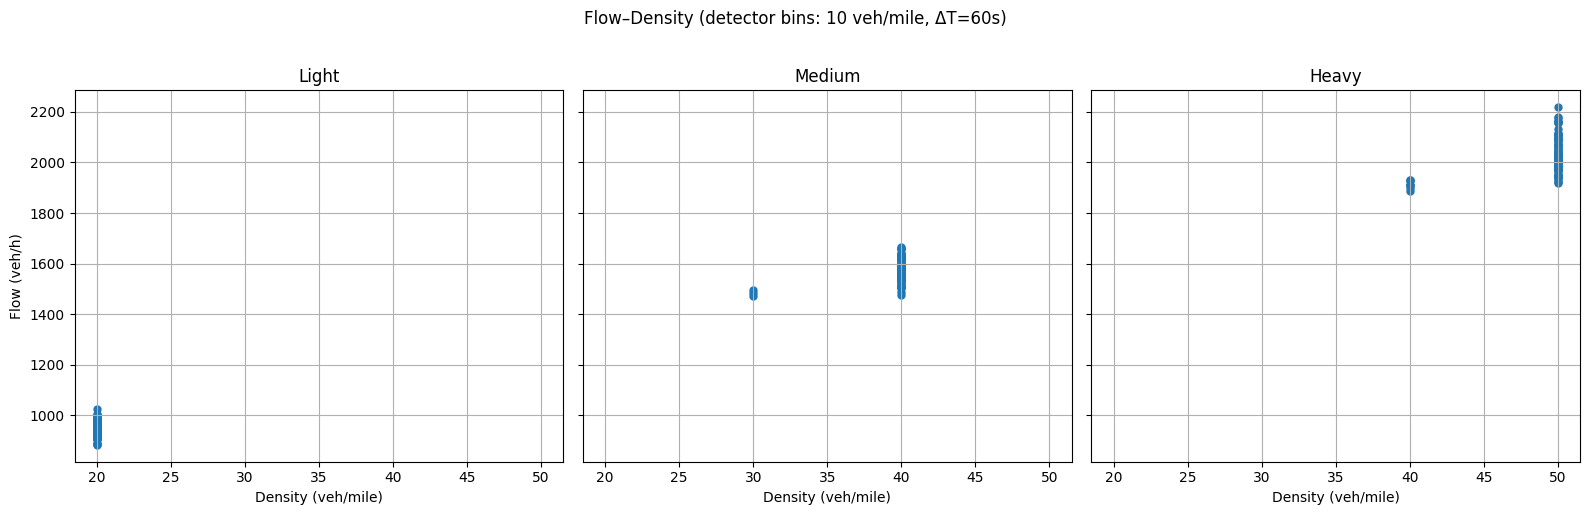

Saved: FD_mainline_corridor_per_mile_binned.csv


In [4]:
"""
Flow–Density fundamental diagram (FCD-based) for the COMPLETE MAINLINE (corridor-aggregated),
plotted side-by-side for Light / Medium / Heavy in subplots.

UNITS (as requested):
- density: veh/mile (NOT per lane)
- flow:    veh/hour (NOT per lane)
- speed:   mph

LOOK (as requested):
- "detector-style" density bins (vertical stripes) like your example figure

Method:
At each timestep:
  N_mainline(t) = total vehicles on all mainline edges
  k(t) = N_mainline(t) / L_mainline_miles
  v(t) = length-weighted mean speed across mainline edges (mph)
  q(t) = k(t) * v(t)   [veh/h]

Then aggregate to AGG_SEC bins and plot q vs binned k.
"""

from pathlib import Path
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# USER SETTINGS
# -----------------------------
SCENARIOS = {
    "Light":  r"Light/Output-Default-Priority",
    "Medium": r"Medium/Output-Default-Priority",
    "Heavy":  r"Heavy/Output-Default-Priority",
}

FCD_NAME = "fcd.xml"

# Net file is in project ROOT (not inside scenario folders)
NET_XML = Path("Default-priority-network.net.xml")

WARMUP_SEC = 600.0
END_SEC = None          # e.g., 6000.0
AGG_SEC = 60.0          # time bin size in seconds

# Detector-style density binning (controls the "vertical columns" look)
DENSITY_BIN_WIDTH = 10.0  # veh/mile (try 5, 10, 20)

MAINLINE_EDGES = [
    "53187125","99457879","99457861","99457865","1447866124","99457871","1040199894",
    "99457868","99457881","99457867","1040187307","1040187306","54582833","54582832",
    "998964264","1040190012","54641968","54618319","726591114","726591113","726591150",
    "726591149","103504797","103504792","103504816","103504815","50487000","518352630"
]

# -----------------------------
# CONSTANTS
# -----------------------------
M_PER_MILE = 1609.344
MS_TO_MPH = 2.2369362920544

# -----------------------------
# NETWORK PARSING: edge lengths (meters)
# -----------------------------
def read_net_edge_lengths(net_xml: Path) -> dict:
    if not net_xml.exists():
        raise FileNotFoundError(f"NET XML not found: {net_xml.resolve()}")

    tree = ET.parse(net_xml)
    root = tree.getroot()

    edge_len_m = {}
    for e in root.findall("edge"):
        eid = e.get("id")
        if eid is None or eid.startswith(":"):
            continue
        lanes = e.findall("lane")
        if not lanes:
            continue
        edge_len_m[eid] = float(lanes[0].get("length"))  # meters

    return edge_len_m

# -----------------------------
# FCD STREAMING: compute corridor time series
# -----------------------------
def mainline_time_series_from_fcd(
    fcd_xml: Path,
    edge_len_m: dict,
    mainline_edges: list[str],
    warmup_sec: float,
    end_sec: float | None
) -> pd.DataFrame:
    """
    Returns per-timestep corridor series:
      time, N_mainline, density_veh_per_mile, speed_mph, flow_vph

    Notes:
    - density is computed using total vehicles on mainline / total mainline miles
    - speed is length-weighted mean of edge mean speeds
    - flow computed via q = k * v
    """
    if not fcd_xml.exists():
        raise FileNotFoundError(f"FCD not found: {fcd_xml.resolve()}")

    mainline_set = set(mainline_edges)

    # total mainline length
    L_mainline_m = sum(edge_len_m[e] for e in mainline_edges if e in edge_len_m)
    if L_mainline_m <= 0:
        missing = [e for e in mainline_edges if e not in edge_len_m]
        raise ValueError(
            "Mainline length computed as 0. Check edge IDs match net.xml.\n"
            f"Missing edges (first 10): {missing[:10]}"
        )
    L_mainline_miles = L_mainline_m / M_PER_MILE

    rows = []
    context = ET.iterparse(fcd_xml, events=("start", "end"))
    _, root = next(context)

    current_time = None
    counts = {}
    speed_sums = {}

    for event, elem in context:
        if event == "start" and elem.tag == "timestep":
            current_time = float(elem.get("time"))
            counts = {}
            speed_sums = {}

        elif event == "end" and elem.tag == "vehicle":
            if current_time is None:
                continue
            if current_time < warmup_sec:
                continue
            if end_sec is not None and current_time > end_sec:
                continue

            lane_id = elem.get("lane")
            if lane_id is None:
                continue

            # lane id like "edgeID_0" -> edgeID
            edge_id = lane_id.rsplit("_", 1)[0]

            if edge_id not in mainline_set:
                continue
            if edge_id not in edge_len_m:
                continue

            v_ms = float(elem.get("speed", "0.0"))
            counts[edge_id] = counts.get(edge_id, 0) + 1
            speed_sums[edge_id] = speed_sums.get(edge_id, 0.0) + v_ms

        elif event == "end" and elem.tag == "timestep":
            if current_time is not None and current_time >= warmup_sec and (end_sec is None or current_time <= end_sec):
                # total vehicles on mainline
                N_mainline = sum(counts.values())

                # density veh/mile (not per lane)
                density = N_mainline / L_mainline_miles

                # length-weighted mainline speed (mph)
                num = 0.0
                den = 0.0
                for e, n in counts.items():
                    if n <= 0:
                        continue
                    Lm = edge_len_m.get(e, 0.0)
                    if Lm <= 0:
                        continue
                    v_edge_ms = speed_sums[e] / n
                    num += v_edge_ms * Lm
                    den += Lm

                v_mainline_ms = (num / den) if den > 0 else 0.0
                v_mainline_mph = v_mainline_ms * MS_TO_MPH

                # flow veh/h (not per lane)
                flow = density * v_mainline_mph

                rows.append((current_time, N_mainline, density, v_mainline_mph, flow))

            # memory cleanup
            elem.clear()
            root.clear()

    return pd.DataFrame(
        rows,
        columns=["time", "N_mainline", "density_veh_per_mile", "speed_mph", "flow_vph"]
    )

# -----------------------------
# AGGREGATION: time bins
# -----------------------------
def aggregate_bins(df: pd.DataFrame, agg_sec: float) -> pd.DataFrame:
    if df.empty:
        return df

    out = df.copy()
    out["bin"] = (out["time"] // agg_sec).astype(int)

    agg = (
        out.groupby("bin", as_index=False)
           .agg(
               time_start=("time", "min"),
               time_end=("time", "max"),
               density_veh_per_mile=("density_veh_per_mile", "mean"),
               flow_vph=("flow_vph", "mean"),
               speed_mph=("speed_mph", "mean"),
               N_mainline=("N_mainline", "mean"),
           )
    )
    return agg

# -----------------------------
# MAIN
# -----------------------------
def main():
    edge_len_m = read_net_edge_lengths(NET_XML)

    fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)

    all_fd = []

    for ax, (scenario_name, folder) in zip(axes, SCENARIOS.items()):
        fcd_path = Path(folder) / FCD_NAME

        ts = mainline_time_series_from_fcd(
            fcd_path, edge_len_m, MAINLINE_EDGES, WARMUP_SEC, END_SEC
        )
        fd = aggregate_bins(ts, AGG_SEC)

        # "detector-style" density bins -> vertical stripes
        fd["density_bin"] = (fd["density_veh_per_mile"] / DENSITY_BIN_WIDTH).round() * DENSITY_BIN_WIDTH

        fd["scenario"] = scenario_name
        all_fd.append(fd)

        if fd.empty:
            ax.set_title(f"{scenario_name} (no data)")
            ax.grid(True)
            continue

        ax.scatter(fd["density_bin"], fd["flow_vph"], s=25)
        ax.set_title(f"{scenario_name}")
        ax.set_xlabel("Density (veh/mile)")
        ax.grid(True)

    axes[0].set_ylabel("Flow (veh/h)")
    plt.suptitle(f"Flow–Density (detector bins: {DENSITY_BIN_WIDTH:g} veh/mile, ΔT={AGG_SEC:.0f}s)", y=1.02)
    plt.tight_layout()
    plt.show()

    df_all = pd.concat(all_fd, ignore_index=True) if all_fd else pd.DataFrame()
    df_all.to_csv("FD_mainline_corridor_per_mile_binned.csv", index=False)
    print("Saved: FD_mainline_corridor_per_mile_binned.csv")

if __name__ == "__main__":
    main()


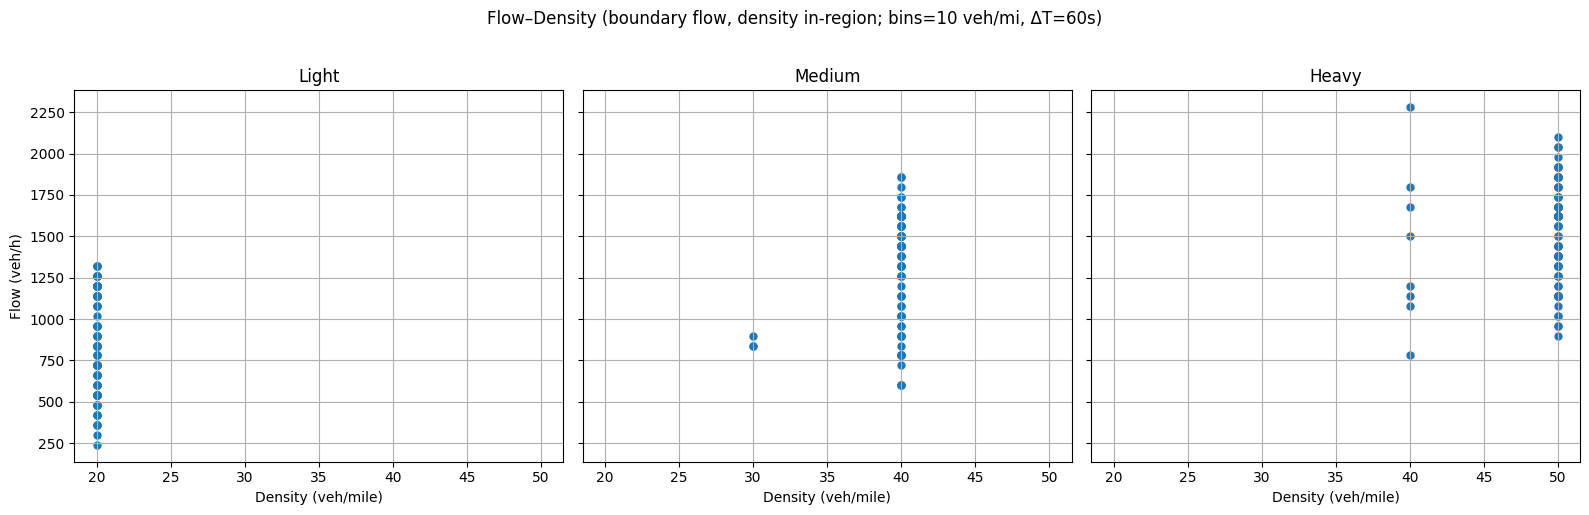

Saved: FD_mainline_corridor_boundaryflow_permile.csv


In [5]:
from pathlib import Path
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# USER SETTINGS
# -----------------------------
SCENARIOS = {
    "Light":  r"Light/Output-Default-Priority",
    "Medium": r"Medium/Output-Default-Priority",
    "Heavy":  r"Heavy/Output-Default-Priority",
}

FCD_NAME = "fcd.xml"
NET_XML = Path("Default-priority-network.net.xml")

WARMUP_SEC = 600.0
END_SEC = None
AGG_SEC = 60.0

# detector-style density binning for the plot look
DENSITY_BIN_WIDTH = 10.0  # veh/mile (try 5 or 10)

MAINLINE_EDGES = [
    "53187125","99457879","99457861","99457865","1447866124","99457871","1040199894",
    "99457868","99457881","99457867","1040187307","1040187306","54582833","54582832",
    "998964264","1040190012","54641968","54618319","726591114","726591113","726591150",
    "726591149","103504797","103504792","103504816","103504815","50487000","518352630"
]

# boundary edge: downstream end of mainline
DOWNSTREAM_EDGE = MAINLINE_EDGES[-1]

M_PER_MILE = 1609.344

# -----------------------------
# NETWORK: edge lengths (meters)
# -----------------------------
def read_net_edge_lengths(net_xml: Path) -> dict:
    tree = ET.parse(net_xml)
    root = tree.getroot()
    edge_len_m = {}
    for e in root.findall("edge"):
        eid = e.get("id")
        if eid is None or eid.startswith(":"):
            continue
        lanes = e.findall("lane")
        if lanes:
            edge_len_m[eid] = float(lanes[0].get("length"))
    return edge_len_m

# -----------------------------
# FCD STREAM:
# density = # vehicles in region / region length
# flow    = # vehicles that newly enter DOWNSTREAM_EDGE in window
# -----------------------------
def corridor_density_flow_from_fcd(
    fcd_xml: Path,
    edge_len_m: dict,
    mainline_edges: list[str],
    downstream_edge: str,
    warmup_sec: float,
    end_sec: float | None,
) -> pd.DataFrame:

    mainline_set = set(mainline_edges)

    # corridor length in miles
    L_m = sum(edge_len_m[e] for e in mainline_edges if e in edge_len_m)
    if L_m <= 0:
        raise ValueError("Mainline length is 0. Check edge IDs vs net.xml.")
    L_mi = L_m / M_PER_MILE

    # Track previous edge for each vehicle to detect "entering downstream edge"
    prev_edge_of_vehicle = {}

    rows = []

    context = ET.iterparse(fcd_xml, events=("start", "end"))
    _, root = next(context)

    current_time = None

    # per timestep
    vehicles_on_mainline = set()
    entered_downstream_count = 0

    for event, elem in context:
        if event == "start" and elem.tag == "timestep":
            current_time = float(elem.get("time"))
            vehicles_on_mainline = set()
            entered_downstream_count = 0

        elif event == "end" and elem.tag == "vehicle":
            if current_time is None:
                continue
            if current_time < warmup_sec:
                continue
            if end_sec is not None and current_time > end_sec:
                continue

            vid = elem.get("id")
            lane_id = elem.get("lane")
            if vid is None or lane_id is None:
                continue

            edge_id = lane_id.rsplit("_", 1)[0]

            # density: count vehicles currently in region
            if edge_id in mainline_set:
                vehicles_on_mainline.add(vid)

            # flow: count vehicles that ENTER downstream edge at this time step
            prev = prev_edge_of_vehicle.get(vid, None)
            if edge_id == downstream_edge and prev != downstream_edge:
                entered_downstream_count += 1

            prev_edge_of_vehicle[vid] = edge_id

        elif event == "end" and elem.tag == "timestep":
            if current_time is not None and current_time >= warmup_sec and (end_sec is None or current_time <= end_sec):
                N = len(vehicles_on_mainline)
                density = N / L_mi  # veh/mile

                rows.append((current_time, N, density, entered_downstream_count))

            elem.clear()
            root.clear()

    df = pd.DataFrame(rows, columns=["time", "N_mainline", "density_veh_per_mile", "entered_downstream"])
    return df

def aggregate_fd(df: pd.DataFrame, agg_sec: float) -> pd.DataFrame:
    if df.empty:
        return df

    out = df.copy()
    out["bin"] = (out["time"] // agg_sec).astype(int)

    agg = (
        out.groupby("bin", as_index=False)
           .agg(
               time_start=("time", "min"),
               time_end=("time", "max"),
               density_veh_per_mile=("density_veh_per_mile", "mean"),
               N_mainline=("N_mainline", "mean"),
               entered_downstream=("entered_downstream", "sum"),
           )
    )

    # Flow as boundary count / window (veh/h)
    agg["flow_vph"] = agg["entered_downstream"] / agg_sec * 3600.0
    return agg

# -----------------------------
# MAIN: subplots
# -----------------------------
edge_len_m = read_net_edge_lengths(NET_XML)

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)
all_fd = []

for ax, (name, folder) in zip(axes, SCENARIOS.items()):
    fcd_path = Path(folder) / FCD_NAME

    ts = corridor_density_flow_from_fcd(
        fcd_path,
        edge_len_m=edge_len_m,
        mainline_edges=MAINLINE_EDGES,
        downstream_edge=DOWNSTREAM_EDGE,
        warmup_sec=WARMUP_SEC,
        end_sec=END_SEC,
    )
    fd = aggregate_fd(ts, AGG_SEC)

    # detector-style density bins
    fd["density_bin"] = (fd["density_veh_per_mile"] / DENSITY_BIN_WIDTH).round() * DENSITY_BIN_WIDTH

    fd["scenario"] = name
    all_fd.append(fd)

    ax.scatter(fd["density_bin"], fd["flow_vph"], s=25)
    ax.set_title(name)
    ax.set_xlabel("Density (veh/mile)")
    ax.grid(True)

axes[0].set_ylabel("Flow (veh/h)")
plt.suptitle(f"Flow–Density (boundary flow, density in-region; bins={DENSITY_BIN_WIDTH:g} veh/mi, ΔT={AGG_SEC:.0f}s)", y=1.02)
plt.tight_layout()
plt.show()

df_all = pd.concat(all_fd, ignore_index=True)
df_all.to_csv("FD_mainline_corridor_boundaryflow_permile.csv", index=False)
print("Saved: FD_mainline_corridor_boundaryflow_permile.csv")


In [9]:
"""
Corridor-level fundamental diagrams from SUMO FCD:
- Flow–Density (q–k)
- Speed–Density (v–k)
- Flow–Speed (q–v)

CORRIDOR (complete mainline):
- density k(t): vehicles in mainline region / mainline length [veh/mi]
- speed  v(t): space-mean speed of vehicles in region [mph] (vehicle-weighted)
- flow   q(t): downstream boundary crossings / window [veh/h]

Plots:
- 3 figures, each with 3 subplots (Light/Medium/Heavy)
- Optional "detector-style" density binning for q–k and v–k look

Notes:
- DOWNSTREAM_EDGE is the last edge in MAINLINE_EDGES.
- Flow counts vehicles that ENTER DOWNSTREAM_EDGE (proxy for reaching downstream).
  If you want "true exit crossing", ask and I’ll provide the pos-based version.
"""

from pathlib import Path
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# USER SETTINGS
# -----------------------------
SCENARIOS = {
    "Light":  r"Light/Output-Default-Priority",
    "Medium": r"Medium/Output-Default-Priority",
    "Heavy":  r"Heavy/Output-Default-Priority",
}

FCD_NAME = "fcd.xml"
NET_XML = Path("Default-priority-network.net.xml")

WARMUP_SEC = 600.0
END_SEC = None          # e.g., 6000.0
AGG_SEC = 60.0          # aggregation window

# Set to None to disable density binning
DENSITY_BIN_WIDTH = 10.0   # veh/mi (try 5 or 10)

MAINLINE_EDGES = [
    "53187125","99457879","99457861","99457865","1447866124","99457871","1040199894",
    "99457868","99457881","99457867","1040187307","1040187306","54582833","54582832",
    "998964264","1040190012","54641968","54618319","726591114","726591113","726591150",
    "726591149","103504797","103504792","103504816","103504815","50487000","518352630"
]
DOWNSTREAM_EDGE = MAINLINE_EDGES[-1]

# -----------------------------
# CONSTANTS
# -----------------------------
M_PER_MILE = 1609.344
MS_TO_MPH = 2.2369362920544

# -----------------------------
# NETWORK: edge lengths (meters)
# -----------------------------
def read_net_edge_lengths(net_xml: Path) -> dict:
    if not net_xml.exists():
        raise FileNotFoundError(f"NET XML not found: {net_xml.resolve()}")

    tree = ET.parse(net_xml)
    root = tree.getroot()

    edge_len_m = {}
    for e in root.findall("edge"):
        eid = e.get("id")
        if eid is None or eid.startswith(":"):
            continue
        lanes = e.findall("lane")
        if lanes:
            edge_len_m[eid] = float(lanes[0].get("length"))
    return edge_len_m

# -----------------------------
# FCD STREAM: per timestep corridor measures
# -----------------------------
def corridor_timeseries_from_fcd(
    fcd_xml: Path,
    edge_len_m: dict,
    mainline_edges: list[str],
    downstream_edge: str,
    warmup_sec: float,
    end_sec: float | None,
) -> pd.DataFrame:
    """
    Returns per timestep:
      time
      N_mainline
      density_veh_per_mi
      speed_mph  (vehicle-weighted mean speed in region)
      entered_downstream (count)  -> used to compute flow later
    """
    if not fcd_xml.exists():
        raise FileNotFoundError(f"FCD not found: {fcd_xml.resolve()}")

    mainline_set = set(mainline_edges)

    # corridor length in miles
    L_m = sum(edge_len_m[e] for e in mainline_edges if e in edge_len_m)
    if L_m <= 0:
        missing = [e for e in mainline_edges if e not in edge_len_m]
        raise ValueError(
            "Mainline length computed as 0. Check edge IDs vs net.xml.\n"
            f"Missing edges (first 10): {missing[:10]}"
        )
    L_mi = L_m / M_PER_MILE

    prev_edge_of_vehicle = {}
    rows = []

    context = ET.iterparse(fcd_xml, events=("start", "end"))
    _, root = next(context)

    current_time = None
    mainline_vehicle_count = 0
    mainline_speed_sum_ms = 0.0
    entered_downstream_count = 0

    for event, elem in context:
        if event == "start" and elem.tag == "timestep":
            current_time = float(elem.get("time"))
            mainline_vehicle_count = 0
            mainline_speed_sum_ms = 0.0
            entered_downstream_count = 0

        elif event == "end" and elem.tag == "vehicle":
            if current_time is None:
                continue
            if current_time < warmup_sec:
                continue
            if end_sec is not None and current_time > end_sec:
                continue

            vid = elem.get("id")
            lane_id = elem.get("lane")
            if vid is None or lane_id is None:
                continue

            edge_id = lane_id.rsplit("_", 1)[0]

            # --- speed in region (vehicle-weighted) ---
            if edge_id in mainline_set:
                v_ms = float(elem.get("speed", "0.0"))
                mainline_vehicle_count += 1
                mainline_speed_sum_ms += v_ms

            # --- boundary flow proxy: entering downstream edge ---
            prev = prev_edge_of_vehicle.get(vid, None)
            if edge_id == downstream_edge and prev != downstream_edge:
                entered_downstream_count += 1
            prev_edge_of_vehicle[vid] = edge_id

        elif event == "end" and elem.tag == "timestep":
            if current_time is not None and current_time >= warmup_sec and (end_sec is None or current_time <= end_sec):
                N = mainline_vehicle_count
                density = N / L_mi  # veh/mi
                v_ms = (mainline_speed_sum_ms / N) if N > 0 else 0.0
                v_mph = v_ms * MS_TO_MPH

                rows.append((current_time, N, density, v_mph, entered_downstream_count))

            elem.clear()
            root.clear()

    return pd.DataFrame(rows, columns=["time", "N_mainline", "density_veh_per_mi", "speed_mph", "entered_downstream"])

# -----------------------------
# Aggregate to time bins and compute flow
# -----------------------------
def aggregate_bins(df: pd.DataFrame, agg_sec: float) -> pd.DataFrame:
    if df.empty:
        return df

    out = df.copy()
    out["bin"] = (out["time"] // agg_sec).astype(int)

    agg = (
        out.groupby("bin", as_index=False)
           .agg(
               time_start=("time", "min"),
               time_end=("time", "max"),
               density_veh_per_mi=("density_veh_per_mi", "mean"),
               speed_mph=("speed_mph", "mean"),
               N_mainline=("N_mainline", "mean"),
               entered_downstream=("entered_downstream", "sum"),
           )
    )

    # boundary flow (veh/h)
    agg["flow_vph"] = agg["entered_downstream"] / agg_sec * 3600.0

    # optional density binning for plotting look
    if DENSITY_BIN_WIDTH is not None and DENSITY_BIN_WIDTH > 0:
        agg["density_bin"] = (agg["density_veh_per_mi"] / DENSITY_BIN_WIDTH).round() * DENSITY_BIN_WIDTH
    else:
        agg["density_bin"] = agg["density_veh_per_mi"]

    return agg

# -----------------------------
# Plot helpers
# -----------------------------
def plot_three_scenarios(fd_by_scn: dict, xcol: str, ycol: str, xlabel: str, ylabel: str, title: str):
    fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)

    for ax, (name, df) in zip(axes, fd_by_scn.items()):
        if df.empty:
            ax.set_title(f"{name} (no data)")
            ax.grid(True)
            continue

        ax.scatter(df[xcol], df[ycol], s=25)
        ax.set_title(name)
        ax.set_xlabel(xlabel)
        ax.grid(True)

    axes[0].set_ylabel(ylabel)
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

# -----------------------------
# MAIN
# -----------------------------
def main():
    edge_len_m = read_net_edge_lengths(NET_XML)

    fd_by_scn = {}
    all_fd = []

    for name, folder in SCENARIOS.items():
        fcd_path = Path(folder) / FCD_NAME

        ts = corridor_timeseries_from_fcd(
            fcd_path,
            edge_len_m=edge_len_m,
            mainline_edges=MAINLINE_EDGES,
            downstream_edge=DOWNSTREAM_EDGE,
            warmup_sec=WARMUP_SEC,
            end_sec=END_SEC,
        )
        fd = aggregate_bins(ts, AGG_SEC)
        fd["scenario"] = name
        fd_by_scn[name] = fd
        all_fd.append(fd)

    # # 1) Flow–Density
    # plot_three_scenarios(
    #     fd_by_scn,
    #     xcol="density_bin",  # binned density for detector look
    #     ycol="flow_vph",
    #     xlabel="Density (veh/mile)",
    #     ylabel="Flow (veh/h)",
    #     title=f"Flow–Density (boundary flow; density bins={DENSITY_BIN_WIDTH} veh/mi, ΔT={AGG_SEC:.0f}s)"
    # )

    # # 2) Speed–Density
    # plot_three_scenarios(
    #     fd_by_scn,
    #     xcol="density_bin",
    #     ycol="speed_mph",
    #     xlabel="Density (veh/mile)",
    #     ylabel="Speed (mph)",
    #     # title=f"Speed–Density (space-mean in-region; density bins={DENSITY_BIN_WIDTH} veh/mi, ΔT={AGG_SEC:.0f}s)"
    # )

    # 3) Flow–Speed
    plot_three_scenarios(
        fd_by_scn,
        xcol="speed_mph",
        ycol="flow_vph",
        xlabel="Speed (mph)",
        ylabel="Flow (veh/h)",
        # title=f"Flow–Speed (boundary flow; ΔT={AGG_SEC:.0f}s)"
    )

    # Save combined
    df_all = pd.concat(all_fd, ignore_index=True) if all_fd else pd.DataFrame()
    df_all.to_csv("FD_corridor_all_three_diagrams_data.csv", index=False)
    print("Saved: FD_corridor_all_three_diagrams_data.csv")

if __name__ == "__main__":
    main()


TypeError: plot_three_scenarios() missing 1 required positional argument: 'title'

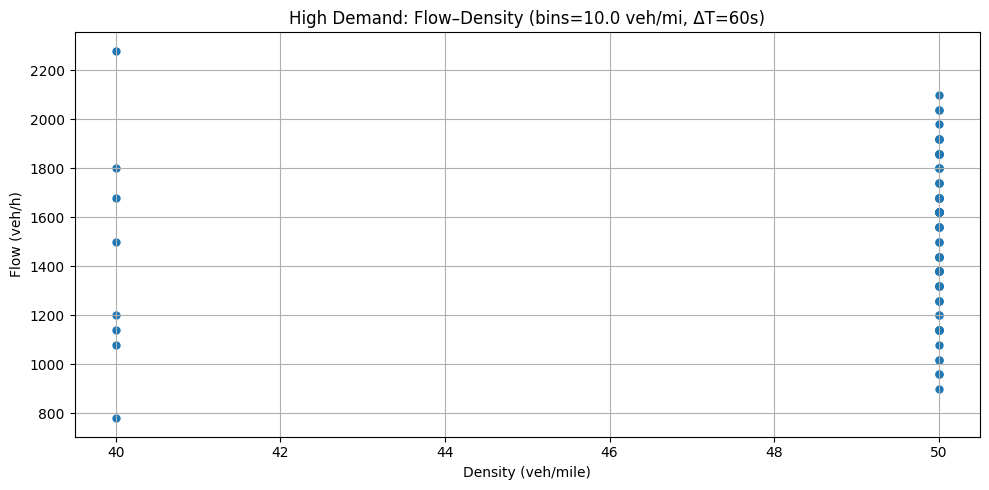

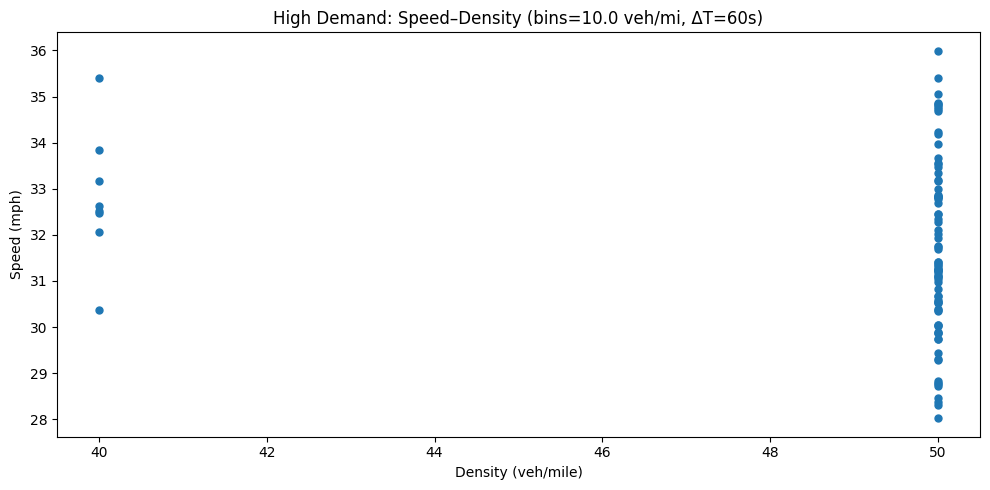

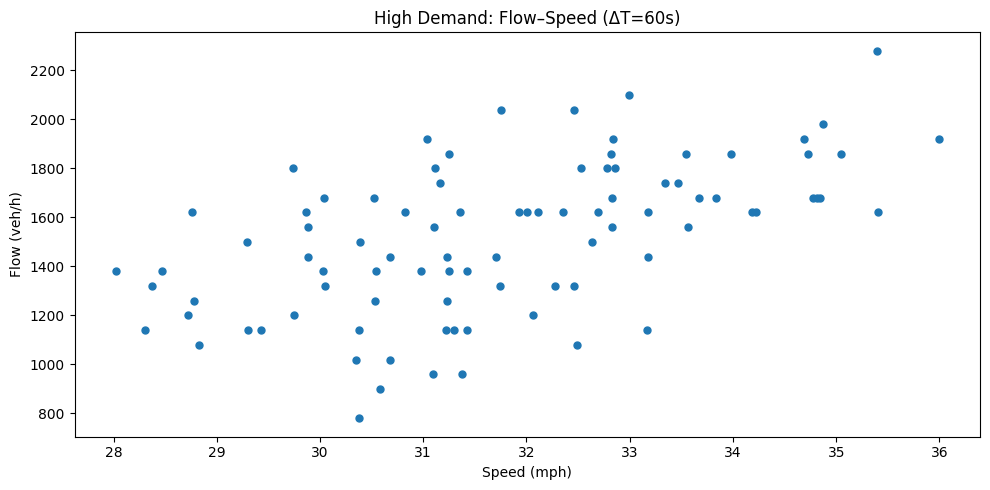

Saved: FD_high_demand_corridor_data.csv


In [22]:
"""
Corridor-level fundamental diagrams from SUMO FCD for ONLY HIGH demand:
- Flow–Density (q–k)
- Speed–Density (v–k)
- Flow–Speed (q–v)

CORRIDOR (complete mainline):
- density k(t): vehicles in mainline region / mainline length [veh/mi]
- speed  v(t): space-mean speed of vehicles in region [mph] (vehicle-weighted)
- flow   q(t): downstream boundary crossings / window [veh/h]

Notes:
- DOWNSTREAM_EDGE is the last edge in MAINLINE_EDGES.
- Flow counts vehicles that ENTER DOWNSTREAM_EDGE (proxy for reaching downstream).
"""

from pathlib import Path
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# USER SETTINGS (HIGH ONLY)
# -----------------------------
HIGH_FOLDER = r"Heavy/Output-Default-Priority"

FCD_NAME = "fcd.xml"
NET_XML = Path("Default-priority-network.net.xml")

WARMUP_SEC = 600.0
END_SEC = None          # e.g., 6000.0
AGG_SEC = 60.0          # aggregation window

# Set to None to disable density binning
DENSITY_BIN_WIDTH = 10.0   # veh/mi (try 5 or 10)

MAINLINE_EDGES = [
    "53187125","99457879","99457861","99457865","1447866124","99457871","1040199894",
    "99457868","99457881","99457867","1040187307","1040187306","54582833","54582832",
    "998964264","1040190012","54641968","54618319","726591114","726591113","726591150",
    "726591149","103504797","103504792","103504816","103504815","50487000","518352630"
]
DOWNSTREAM_EDGE = MAINLINE_EDGES[-1]

# -----------------------------
# CONSTANTS
# -----------------------------
M_PER_MILE = 1609.344
MS_TO_MPH = 2.2369362920544

# -----------------------------
# NETWORK: edge lengths (meters)
# -----------------------------
def read_net_edge_lengths(net_xml: Path) -> dict:
    if not net_xml.exists():
        raise FileNotFoundError(f"NET XML not found: {net_xml.resolve()}")

    tree = ET.parse(net_xml)
    root = tree.getroot()

    edge_len_m = {}
    for e in root.findall("edge"):
        eid = e.get("id")
        if eid is None or eid.startswith(":"):
            continue
        lanes = e.findall("lane")
        if lanes:
            edge_len_m[eid] = float(lanes[0].get("length"))
    return edge_len_m

# -----------------------------
# FCD STREAM: per timestep corridor measures
# -----------------------------
def corridor_timeseries_from_fcd(
    fcd_xml: Path,
    edge_len_m: dict,
    mainline_edges: list[str],
    downstream_edge: str,
    warmup_sec: float,
    end_sec: float | None,
) -> pd.DataFrame:
    """
    Returns per timestep:
      time
      N_mainline
      density_veh_per_mi
      speed_mph  (vehicle-weighted mean speed in region)
      entered_downstream (count)  -> used to compute flow later
    """
    if not fcd_xml.exists():
        raise FileNotFoundError(f"FCD not found: {fcd_xml.resolve()}")

    mainline_set = set(mainline_edges)

    # corridor length in miles
    L_m = sum(edge_len_m[e] for e in mainline_edges if e in edge_len_m)
    if L_m <= 0:
        missing = [e for e in mainline_edges if e not in edge_len_m]
        raise ValueError(
            "Mainline length computed as 0. Check edge IDs vs net.xml.\n"
            f"Missing edges (first 10): {missing[:10]}"
        )
    L_mi = L_m / M_PER_MILE

    prev_edge_of_vehicle = {}
    rows = []

    context = ET.iterparse(fcd_xml, events=("start", "end"))
    _, root = next(context)

    current_time = None
    mainline_vehicle_count = 0
    mainline_speed_sum_ms = 0.0
    entered_downstream_count = 0

    for event, elem in context:
        if event == "start" and elem.tag == "timestep":
            current_time = float(elem.get("time"))
            mainline_vehicle_count = 0
            mainline_speed_sum_ms = 0.0
            entered_downstream_count = 0

        elif event == "end" and elem.tag == "vehicle":
            if current_time is None:
                continue
            if current_time < warmup_sec:
                continue
            if end_sec is not None and current_time > end_sec:
                continue

            vid = elem.get("id")
            lane_id = elem.get("lane")
            if vid is None or lane_id is None:
                continue

            edge_id = lane_id.rsplit("_", 1)[0]

            # --- speed in region (vehicle-weighted) ---
            if edge_id in mainline_set:
                v_ms = float(elem.get("speed", "0.0"))
                mainline_vehicle_count += 1
                mainline_speed_sum_ms += v_ms

            # --- boundary flow proxy: entering downstream edge ---
            prev = prev_edge_of_vehicle.get(vid, None)
            if edge_id == downstream_edge and prev != downstream_edge:
                entered_downstream_count += 1
            prev_edge_of_vehicle[vid] = edge_id

        elif event == "end" and elem.tag == "timestep":
            if current_time is not None and current_time >= warmup_sec and (end_sec is None or current_time <= end_sec):
                N = mainline_vehicle_count
                density = N / L_mi  # veh/mi
                v_ms = (mainline_speed_sum_ms / N) if N > 0 else 0.0
                v_mph = v_ms * MS_TO_MPH

                rows.append((current_time, N, density, v_mph, entered_downstream_count))

            elem.clear()
            root.clear()

    return pd.DataFrame(rows, columns=["time", "N_mainline", "density_veh_per_mi", "speed_mph", "entered_downstream"])

# -----------------------------
# Aggregate to time bins and compute flow
# -----------------------------
def aggregate_bins(df: pd.DataFrame, agg_sec: float) -> pd.DataFrame:
    if df.empty:
        return df

    out = df.copy()
    out["bin"] = (out["time"] // agg_sec).astype(int)

    agg = (
        out.groupby("bin", as_index=False)
           .agg(
               time_start=("time", "min"),
               time_end=("time", "max"),
               density_veh_per_mi=("density_veh_per_mi", "mean"),
               speed_mph=("speed_mph", "mean"),
               N_mainline=("N_mainline", "mean"),
               entered_downstream=("entered_downstream", "sum"),
           )
    )

    # boundary flow (veh/h)
    agg["flow_vph"] = agg["entered_downstream"] / agg_sec * 3600.0

    # optional density binning
    if DENSITY_BIN_WIDTH is not None and DENSITY_BIN_WIDTH > 0:
        agg["density_bin"] = (agg["density_veh_per_mi"] / DENSITY_BIN_WIDTH).round() * DENSITY_BIN_WIDTH
    else:
        agg["density_bin"] = agg["density_veh_per_mi"]

    return agg

# -----------------------------
# MAIN
# -----------------------------
def main():
    edge_len_m = read_net_edge_lengths(NET_XML)

    fcd_path = Path(HIGH_FOLDER) / FCD_NAME
    ts = corridor_timeseries_from_fcd(
        fcd_path,
        edge_len_m=edge_len_m,
        mainline_edges=MAINLINE_EDGES,
        downstream_edge=DOWNSTREAM_EDGE,
        warmup_sec=WARMUP_SEC,
        end_sec=END_SEC,
    )
    fd = aggregate_bins(ts, AGG_SEC)

    if fd.empty:
        print("No data after filtering. Check WARMUP_SEC/END_SEC and file paths.")
        return

    # 1) Flow–Density
    plt.figure(figsize=(10, 5))
    plt.scatter(fd["density_bin"], fd["flow_vph"], s=25)
    plt.title(f"High Demand: Flow–Density (bins={DENSITY_BIN_WIDTH} veh/mi, ΔT={AGG_SEC:.0f}s)")
    plt.xlabel("Density (veh/mile)")
    plt.ylabel("Flow (veh/h)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2) Speed–Density
    plt.figure(figsize=(10, 5))
    plt.scatter(fd["density_bin"], fd["speed_mph"], s=25)
    plt.title(f"High Demand: Speed–Density (bins={DENSITY_BIN_WIDTH} veh/mi, ΔT={AGG_SEC:.0f}s)")
    plt.xlabel("Density (veh/mile)")
    plt.ylabel("Speed (mph)")
    # plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 3) Flow–Speed
    plt.figure(figsize=(10, 5))
    plt.scatter(fd["speed_mph"], fd["flow_vph"], s=25)
    plt.title(f"High Demand: Flow–Speed (ΔT={AGG_SEC:.0f}s)")
    plt.xlabel("Speed (mph)")
    plt.ylabel("Flow (veh/h)")
    # plt.grid(True)
    plt.tight_layout()
    plt.show()

    fd.to_csv("FD_high_demand_corridor_data.csv", index=False)
    print("Saved: FD_high_demand_corridor_data.csv")

if __name__ == "__main__":
    main()


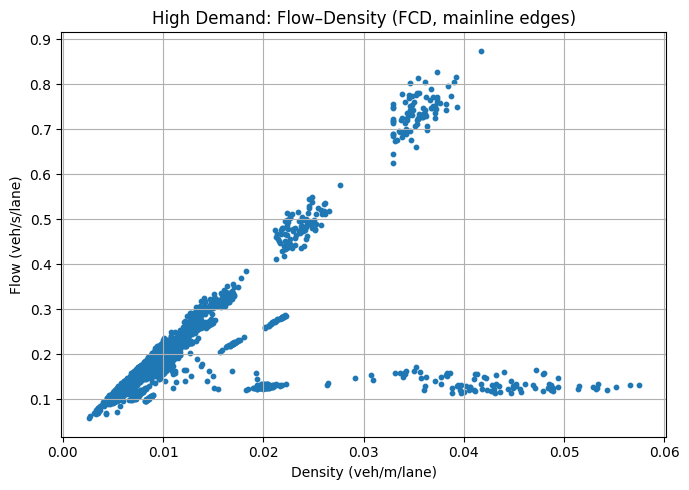

Saved: FD_mainline_fcd_high_per_meter.csv


In [8]:
"""
Flow–Density fundamental diagram (FCD-based) for MAINLINE edges,
ONLY for HIGH demand.

PER-METER UNITS:
- density: veh/m/lane
- flow:    veh/s/lane
- speed:   m/s

Assumptions:
- Net file is in the PROJECT ROOT (single net for all scenarios).
- The High scenario folder contains fcd.xml (or edit FCD_NAME).
"""

from pathlib import Path
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# USER SETTINGS (HIGH ONLY)
# -----------------------------
HIGH_FOLDER = r"Heavy/Output-Default-Priority"   # <-- change if your High folder path differs
FCD_NAME = "fcd.xml"

NET_XML = Path("Default-priority-network.net.xml")

WARMUP_SEC = 600.0
END_SEC = None      # e.g., 6000.0
AGG_SEC = 60.0      # time bin size for FD points

MAINLINE_EDGES = [
    "53187125","99457879","99457861","99457865","1447866124","99457871","1040199894",
    "99457868","99457881","99457867","1040187307","1040187306","54582833","54582832",
    "998964264","1040190012","54641968","54618319","726591114","726591113","726591150",
    "726591149","103504797","103504792","103504816","103504815","50487000","518352630"
]

# -----------------------------
# Helpers
# -----------------------------
def read_net_edge_info(net_xml: Path):
    if not net_xml.exists():
        raise FileNotFoundError(f"NET XML not found: {net_xml.resolve()}")

    tree = ET.parse(net_xml)
    root = tree.getroot()

    edge_len = {}
    edge_lanes = {}

    for e in root.findall("edge"):
        eid = e.get("id")
        if eid is None or eid.startswith(":"):
            continue
        lanes = e.findall("lane")
        if not lanes:
            continue

        length = float(lanes[0].get("length"))  # meters
        nlanes = len(lanes)

        edge_len[eid] = length
        edge_lanes[eid] = nlanes

    return edge_len, edge_lanes


def fcd_edge_time_stats(fcd_xml: Path, edge_len: dict, edge_lanes: dict,
                        warmup_sec: float, end_sec: float | None,
                        corridor_edges: set[str]) -> pd.DataFrame:
    """
    Per timestep & per edge (PER-METER):
      density = N / (L_m * nLanes)      [veh/m/lane]
      v_ms    space-mean speed          [m/s]
      flow    = density * v_ms          [veh/s/lane]
    """
    rows = []
    context = ET.iterparse(fcd_xml, events=("start", "end"))
    _, root = next(context)

    current_time = None
    counts = {}
    speed_sums = {}

    for event, elem in context:
        if event == "start" and elem.tag == "timestep":
            current_time = float(elem.get("time"))
            counts = {}
            speed_sums = {}

        elif event == "end" and elem.tag == "vehicle":
            if current_time is None:
                continue
            if current_time < warmup_sec:
                continue
            if end_sec is not None and current_time > end_sec:
                continue

            lane_id = elem.get("lane")
            if lane_id is None:
                continue

            # lane id like "edgeID_0" -> edgeID
            edge_id = lane_id.rsplit("_", 1)[0]

            if edge_id not in corridor_edges:
                continue
            if edge_id not in edge_len or edge_id not in edge_lanes:
                continue

            v_ms = float(elem.get("speed", "0.0"))
            counts[edge_id] = counts.get(edge_id, 0) + 1
            speed_sums[edge_id] = speed_sums.get(edge_id, 0.0) + v_ms

        elif event == "end" and elem.tag == "timestep":
            if current_time is not None and current_time >= warmup_sec and (end_sec is None or current_time <= end_sec):
                for edge_id, n in counts.items():
                    L_m = edge_len[edge_id]
                    nlanes = edge_lanes[edge_id]
                    if L_m <= 0 or nlanes <= 0:
                        continue

                    v_mean_ms = speed_sums[edge_id] / max(n, 1)

                    # per-meter per-lane
                    density = n / (L_m * nlanes)  # veh/m/lane
                    flow = density * v_mean_ms    # veh/s/lane

                    rows.append((current_time, edge_id, density, flow, v_mean_ms, n))

            elem.clear()
            root.clear()

    return pd.DataFrame(rows, columns=["time", "edge", "density", "flow", "v_ms", "nVeh"])


def aggregate_fd(df: pd.DataFrame, agg_sec: float) -> pd.DataFrame:
    if df.empty:
        return df

    out = df.copy()
    out["bin"] = (out["time"] // agg_sec).astype(int)

    agg = (
        out.groupby(["edge", "bin"], as_index=False)
           .agg(
               time_start=("time", "min"),
               time_end=("time", "max"),
               density=("density", "mean"),
               flow=("flow", "mean"),
               v_ms=("v_ms", "mean"),
               nVeh=("nVeh", "mean"),
           )
    )
    return agg


# -----------------------------
# MAIN (HIGH ONLY)
# -----------------------------
edge_len, edge_lanes = read_net_edge_info(NET_XML)

high_folder = Path(HIGH_FOLDER)
fcd_path = high_folder / FCD_NAME
if not fcd_path.exists():
    raise FileNotFoundError(f"FCD not found: {fcd_path.resolve()}")

df_raw = fcd_edge_time_stats(
    fcd_path,
    edge_len=edge_len,
    edge_lanes=edge_lanes,
    warmup_sec=WARMUP_SEC,
    end_sec=END_SEC,
    corridor_edges=set(MAINLINE_EDGES),
)

df_fd = aggregate_fd(df_raw, AGG_SEC)

# Plot (single plot for High)
plt.figure(figsize=(7, 5))
plt.scatter(df_fd["density"], df_fd["flow"], s=10)
plt.title("High Demand: Flow–Density (FCD, mainline edges)")
plt.xlabel("Density (veh/m/lane)")
plt.ylabel("Flow (veh/s/lane)")
plt.grid(True)
plt.tight_layout()
plt.show()

df_fd.to_csv("FD_mainline_fcd_high_per_meter.csv", index=False)
print("Saved: FD_mainline_fcd_high_per_meter.csv")
